# Imports

In [23]:
%reload_ext autoreload
%autoreload 2

In [24]:
import sys
sys.path.append('/workspace/deep_birth_death/src/')

In [29]:
import pickle
import itertools
import time
import os
import statistics
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.regression import get_regression_metrics, plot_errors, plot_errors_boxplot, predicted_minus_target_vs_target

from tensorflow.keras.models import load_model

In [4]:
pd.options.display.float_format = "{:,.4f}".format

# Results generation

In [5]:
pickle_base = '/workspace/deep_birth_death/deep_learning/pickles/old_sims/dataset_'
res_path = "/workspace/deep_birth_death/deep_learning//models/reg/"
n_tips = ['674', '489', '87']

data = dict()
for i in n_tips:
    with open(pickle_base + i + "_10k.pkl", 'rb') as f:
        data[i] = pickle.load(f)

In [6]:
n_trees_tested = 1000
results = dict()
inf_times = dict()

for i in n_tips:
    print('---', i, 'tips ---')
    results[i] = dict()
    inf_times[i] = dict()
    
    for label in np.unique(data[i]['div_info_test']):
        div_scenario = label.split('/')[1].split('_')[0]
        results[i][div_scenario] = dict()
        inf_times[i][div_scenario] = dict()
        
        
        #Load the model
        nn_model = load_model(model_path + 'model.keras')
        
        #Predict
        start_time = time()
        pred = nn_model.predict(np.expand_dims(data[i]['X_test'][data[i]['div_info_test'] == label], axis=2))
        ex_time = time() - start_time
        print("--- Inference time: ", scenario, "scenario &", ex_time, "seconds ---")  
        
        #Load the real parameter values and the rescale factor for rescaling the predictions  
        y_reg_test = data[i]['y_reg_test'][data[i]['div_info_test'] == label]
        y_reg_test = [np.array(elem) for elem in y_reg_test]
        real = y_reg_test
        
        resc_factor_test = data[i]['resc_factor_test'][data[i]['div_info_test'] == label]
            
        #Rescale the corresponding parameter values     
        if div_scenario == "BD" or div_scenario == "HE" or div_scenario == "SAT":
            
            pred[:, 0] = pred[:, 0] / resc_factor_test
        elif div_scenario == "ME":
            
            pred[:, 0] = pred[:, 0] / resc_factor_test
            pred[:, 2] = pred[:, 2] / resc_factor_test
        else:

            pred[:, 0] = pred[:, 0] / resc_factor_test
            pred[:, 1] = pred[:, 1] / resc_factor_test
            pred[:, 4] = pred[:, 4] / resc_factor_test
            
        #Estimate the errors 
            
        abs_error = abs(pred-real)
        raw_error = pred-real
        r_error = abs((y_pred - real)/ real)
        
        #Save the results
        results[i][div_scenario]['raw_error'] = raw_error
        results[i][div_scenario]['abs_error'] = abs_error
        results[i][div_scenario]['real_values'] = real
        
        results[i][div_scenario]['MAE'] = np.mean(error, axis=0)
        results[i][div_scenario]['MRE'] = np.mean(r_error, axis=0)
        
        inf_times[i][div_scenario] = ex_time
        

--- 674 tips ---
--- Inference time:  BD scenario & norm 0.7258780002593994 seconds ---
--- Inference time:  BD scenario & no_norm 0.5501646995544434 seconds ---
--- Inference time:  HE scenario & norm 0.5547890663146973 seconds ---
--- Inference time:  HE scenario & no_norm 0.5201895236968994 seconds ---
--- Inference time:  ME scenario & norm 0.6010713577270508 seconds ---
--- Inference time:  ME scenario & no_norm 0.5935330390930176 seconds ---
--- Inference time:  SAT scenario & norm 0.4740481376647949 seconds ---
--- Inference time:  SAT scenario & no_norm 0.5045487880706787 seconds ---
--- Inference time:  SR scenario & norm 0.5798695087432861 seconds ---
--- Inference time:  SR scenario & no_norm 0.607093334197998 seconds ---
--- Inference time:  WW scenario & norm 0.6714954376220703 seconds ---
--- Inference time:  WW scenario & no_norm 0.6301524639129639 seconds ---
--- 489 tips ---
--- Inference time:  BD scenario & norm 0.429088830947876 seconds ---
--- Inference time:  BD s

## Inference time

In [7]:
for i in inf_times:
    t = []
    for scenario in inf_times[i]:
        t.append(inf_times[i][scenario])
   
    print(f"\nInference time statistics for {i}:")
    print(f"Mean: {np.mean(t):.4f}")
    print(f"Standard deviation: {np.std(t):.4f}")
    print(f"Minimum: {np.min(t):.4f}")
    print(f"Maximum: {np.max(t):.4f}")


Inference time statistics for 674:
Mean: 0.6012
Standard deviation: 0.0809
Minimum: 0.4740
Maximum: 0.7259

Inference time statistics for 489:
Mean: 0.4002
Standard deviation: 0.0604
Minimum: 0.2786
Maximum: 0.4493

Inference time statistics for 87:
Mean: 0.2852
Standard deviation: 0.0536
Minimum: 0.2248
Maximum: 0.3731


## Training time

In [8]:
for i in n_tips:
    train_times = []
    
    for label in np.unique(data[i]['div_info_test']):
        div_scenario = label.split('/')[1].split('_')[0]
        
        # Load regression model 
        model_path = res_path + div_scenario + '/' + i + "_regression_"

        with open(model_path + 'model_data.pkl', 'rb') as f:
            n_params, train_time = pickle.load(f)
                
        train_times.append(train_time)
    
    print('\nTraining times for', i, 'tips')
    print('-'*5)
    print('Mean:', np.mean(train_times))
    print('Std Dev:', np.std(train_times))
    print('Max:', np.max(train_times))
    print('Min:', np.min(train_times))


Training times for 674 tips
-----
Mean: 97.20514261722565
Std Dev: 16.59524491937827
Max: 120.57813763618469
Min: 74.6568374633789

Training times for 489 tips
-----
Mean: 146.4811460574468
Std Dev: 48.40481179340226
Max: 250.31157898902893
Min: 99.37144064903259

Training times for 87 tips
-----
Mean: 145.38835227489471
Std Dev: 70.85414399153025
Max: 270.30372190475464
Min: 76.76596403121948


## Get regression metrics

In [ ]:
n_tips = ['674', '489', '87']
div_scenarios = ['BD', 'HE', 'ME', 'SAT', 'SR', 'WW']

### MAE

In [15]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios: 
        print(scenario)
        data = get_regression_metrics(results, tip, scenario, 'MAE')
        print(data)

---------674---------
BD
         r      a
MAE 0.1263 0.0754
HE
         r      a
MAE 0.2087 0.0181
ME
         r      a   time   frac
MAE 0.0356 0.0679 5.0581 0.0489
SAT
     lambda 0
MAE    0.0656
SR
        r0     r1     a0     a1   time
MAE 0.0661 0.0234 0.1137 0.0933 4.0077
WW
        r0     r1     a0     a1   time
MAE 0.0339 0.1077 0.1472 0.0873 2.8722
---------489---------
BD
         r      a
MAE 0.1351 0.0744
HE
         r      a
MAE 0.2271 0.0191
ME
         r      a   time   frac
MAE 0.0333 0.0710 5.0220 0.0488
SAT
     lambda 0
MAE    0.0705
SR
        r0     r1     a0     a1   time
MAE 0.0556 0.0209 0.1033 0.0954 3.1034
WW
        r0     r1     a0     a1   time
MAE 0.0322 0.1075 0.1243 0.0851 2.8023
---------87---------
BD
         r      a
MAE 0.2558 0.1120
HE
         r      a
MAE 0.3786 0.0246
ME
         r      a   time   frac
MAE 0.0377 0.0926 5.6388 0.0502
SAT
     lambda 0
MAE    0.1776
SR
        r0     r1     a0     a1   time
MAE 0.0736 0.0211 0.1024 0.0904 3.2904

### MRE

In [ ]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios: 
        print(scenario)
        data = get_regression_metrics(results, tip, scenario, 'MRE')
        print(data)

### Errors boxplots 

---------674---------
BD


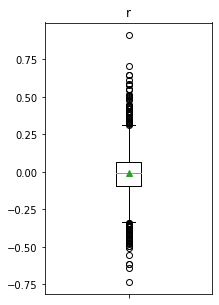

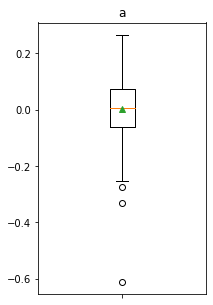

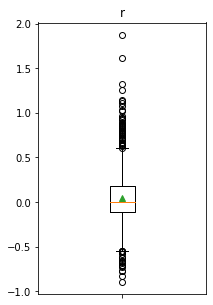

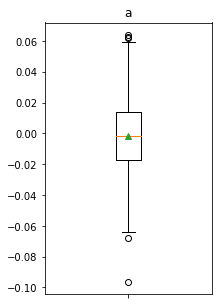

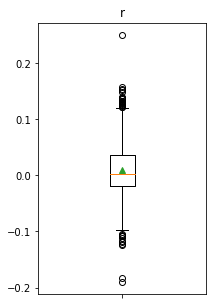

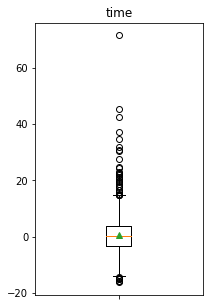

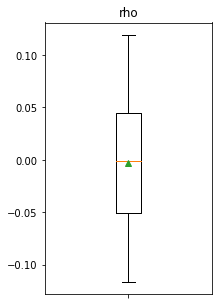

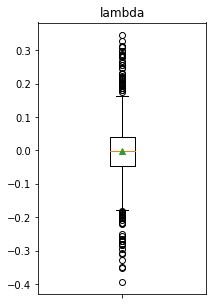

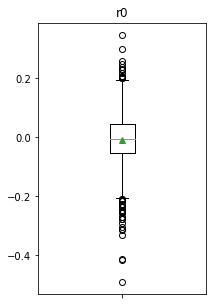

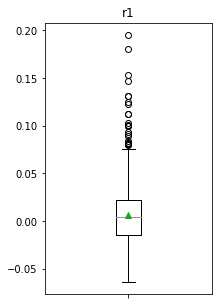

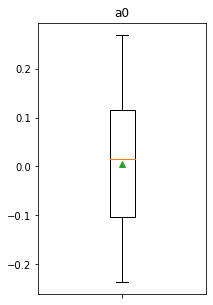

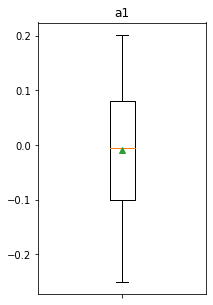

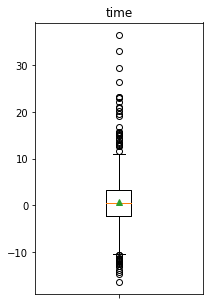

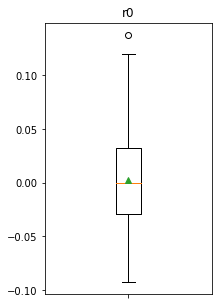

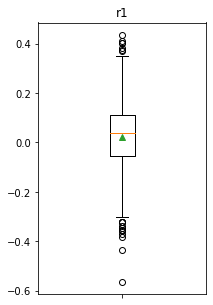

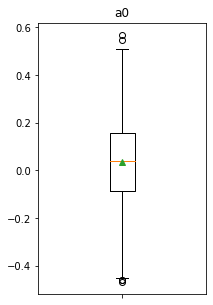

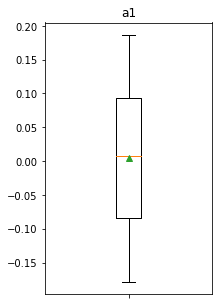

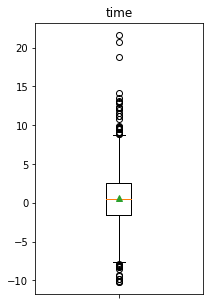

HE


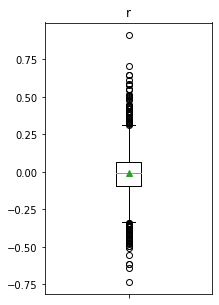

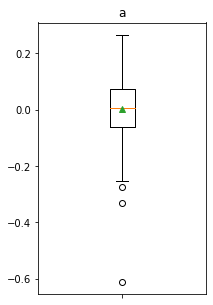

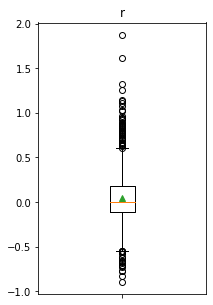

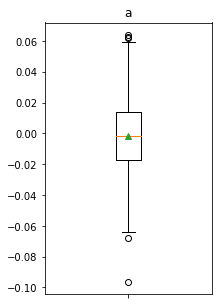

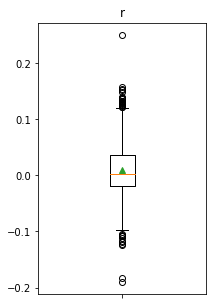

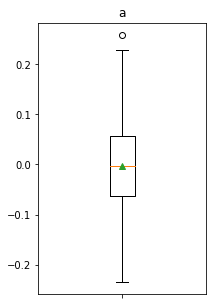

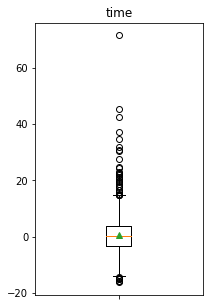

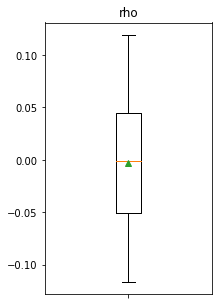

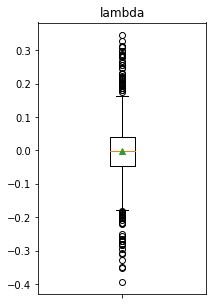

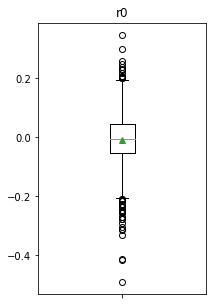

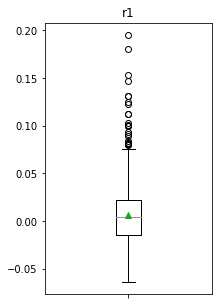

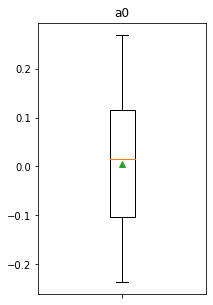

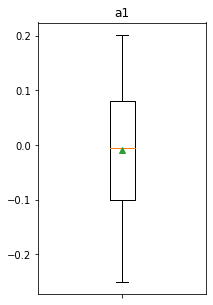

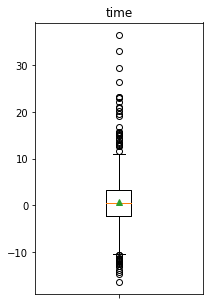

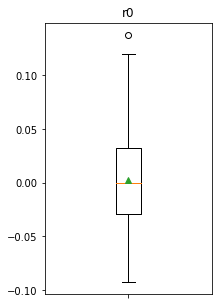

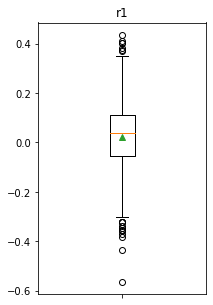

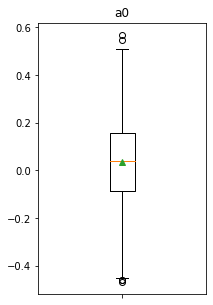

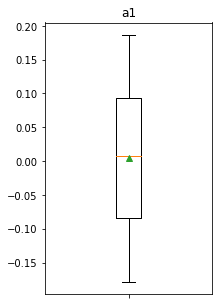

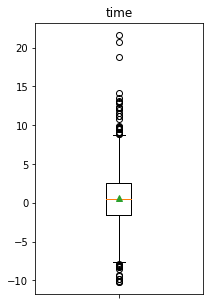

ME


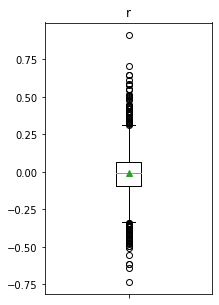

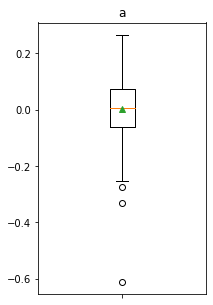

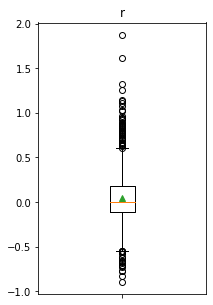

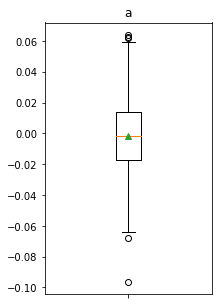

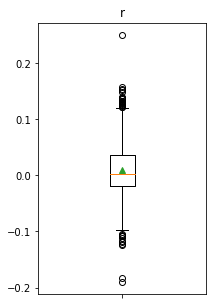

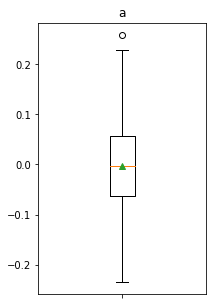

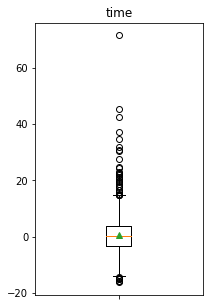

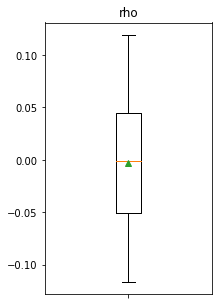

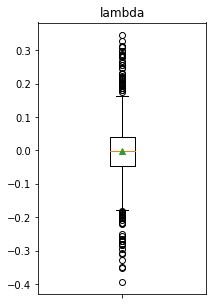

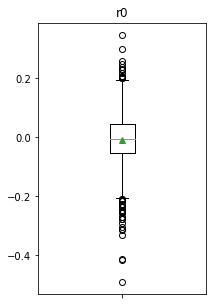

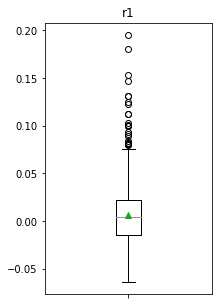

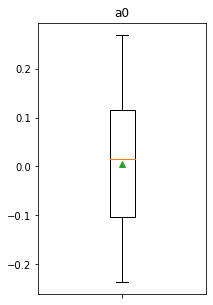

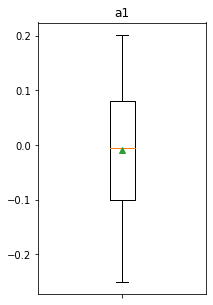

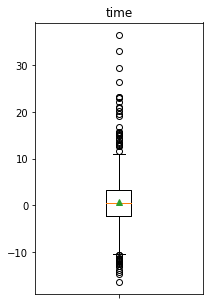

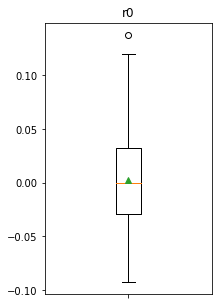

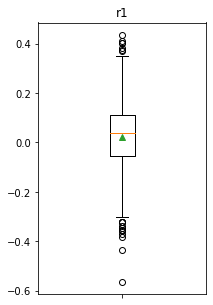

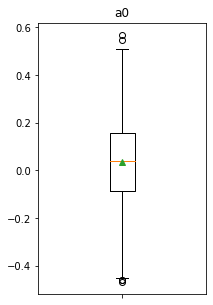

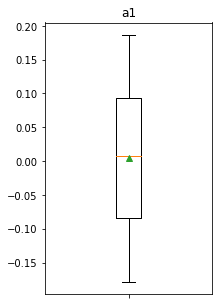

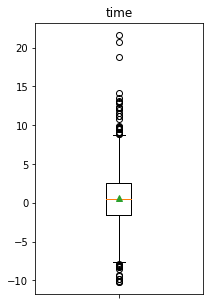

SAT


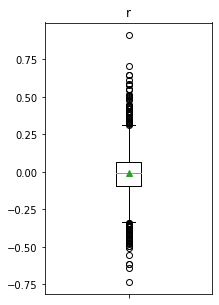

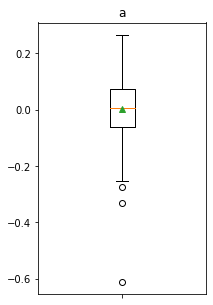

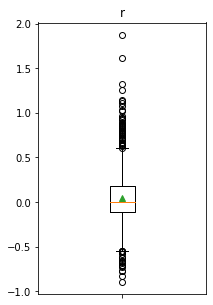

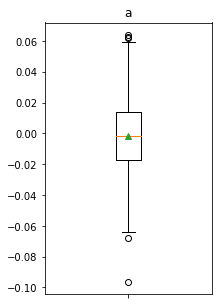

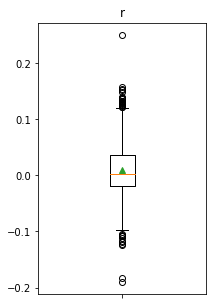

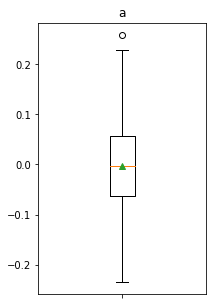

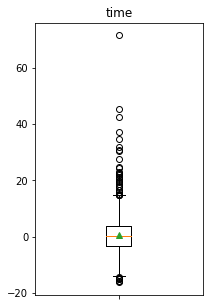

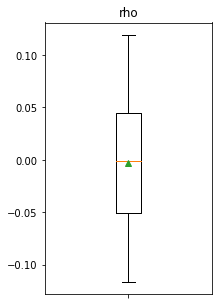

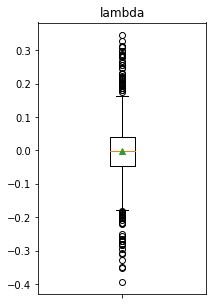

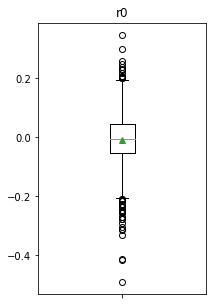

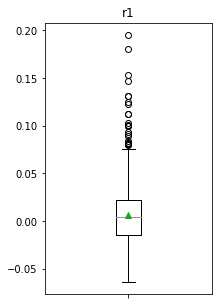

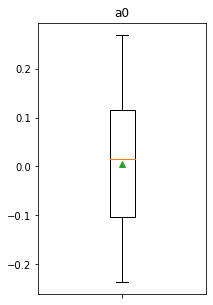

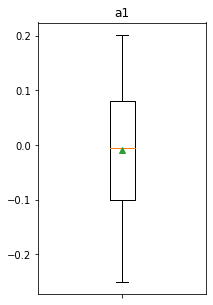

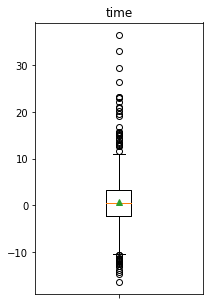

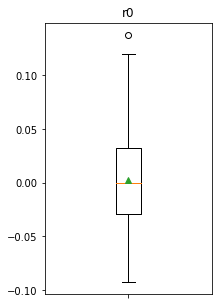

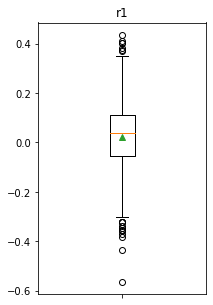

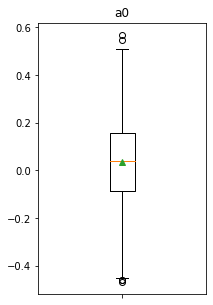

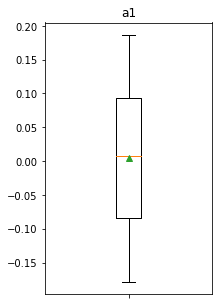

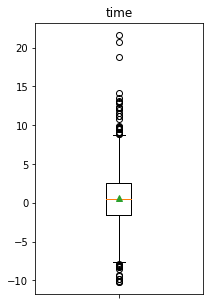

SR


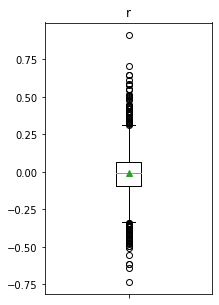

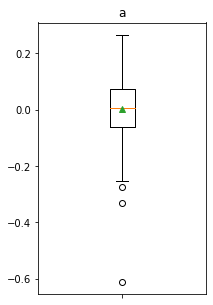

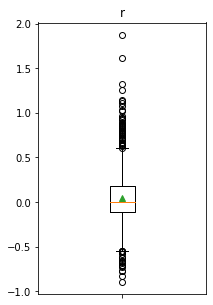

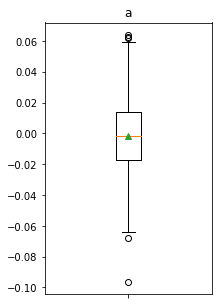

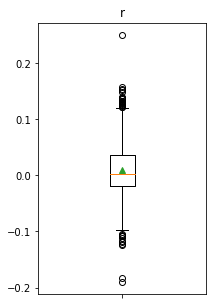

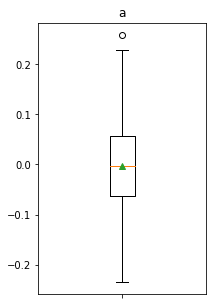

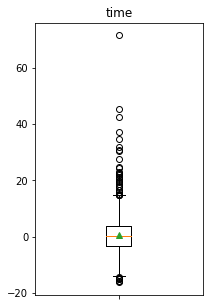

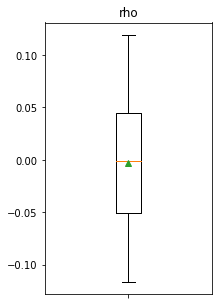

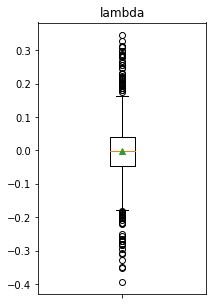

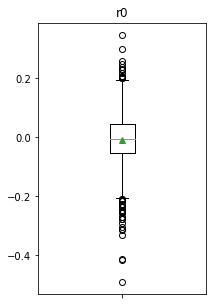

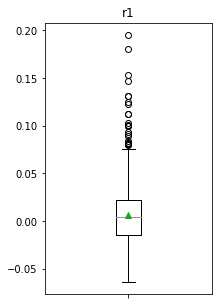

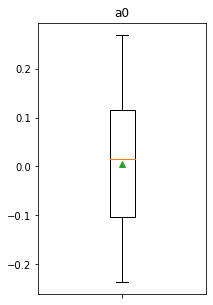

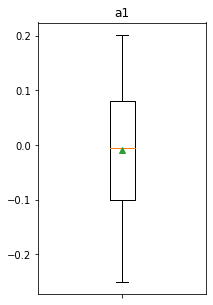

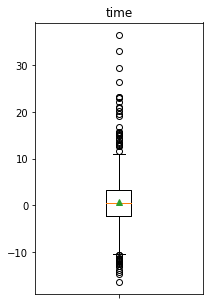

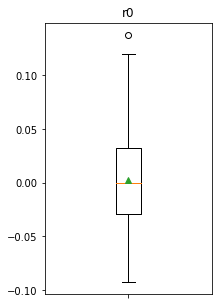

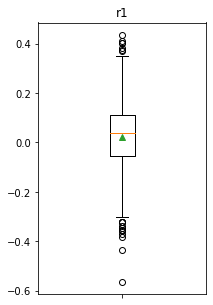

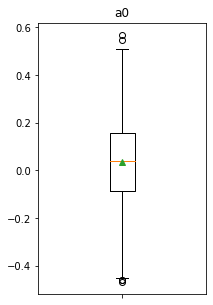

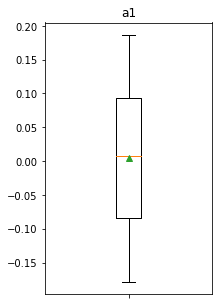

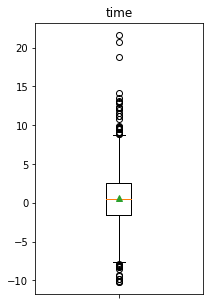

WW


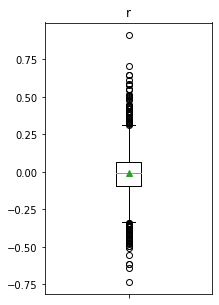

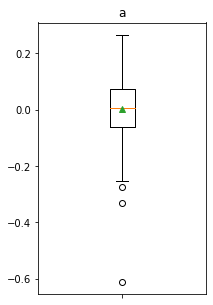

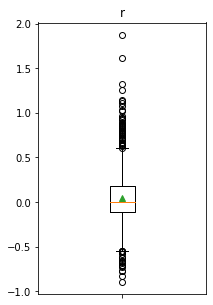

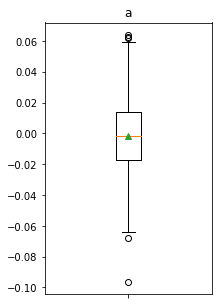

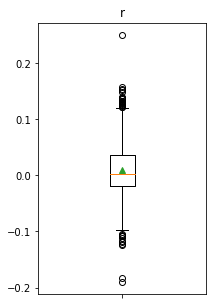

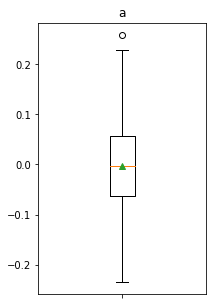

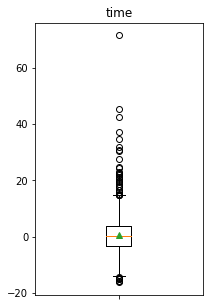

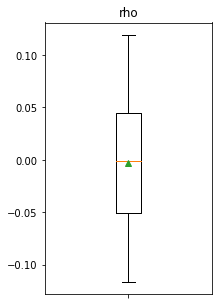

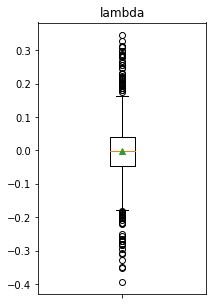

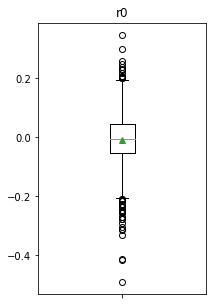

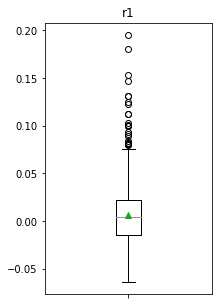

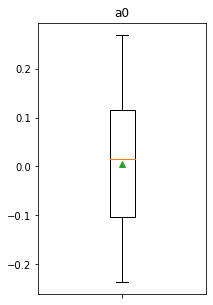

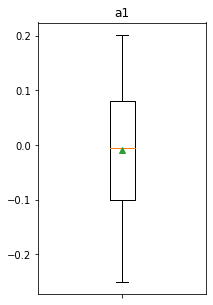

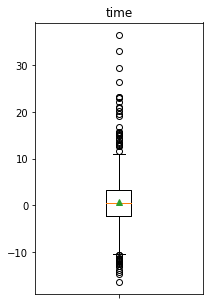

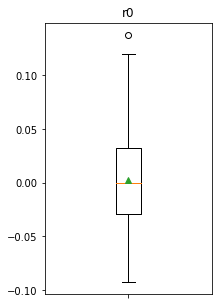

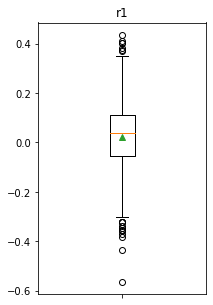

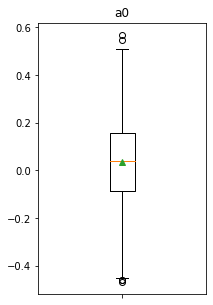

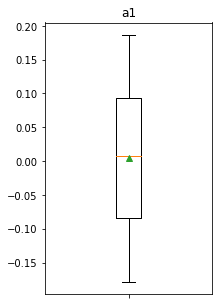

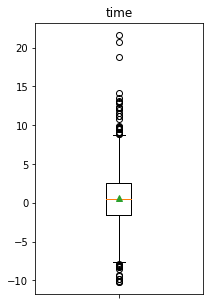

---------489---------
BD


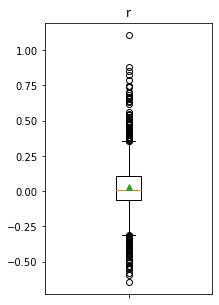

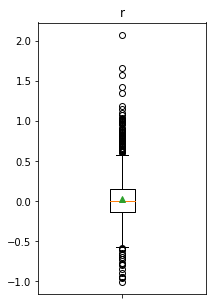

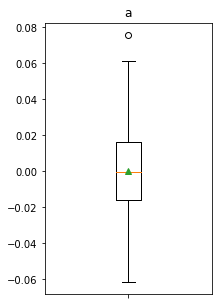

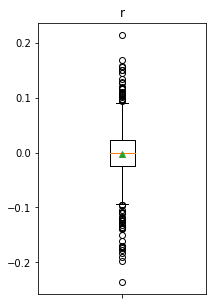

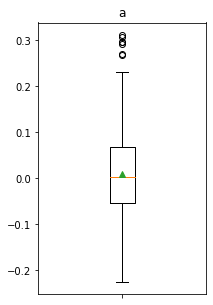

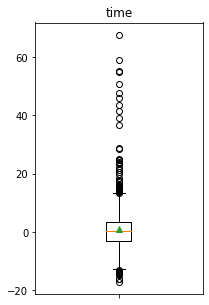

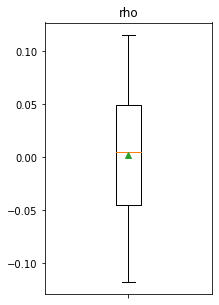

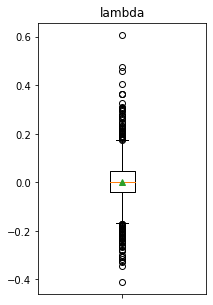

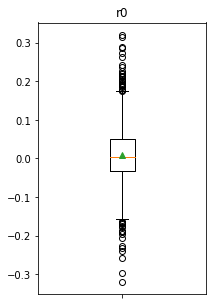

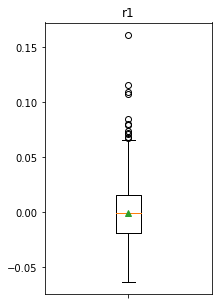

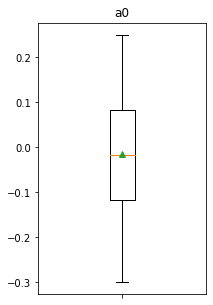

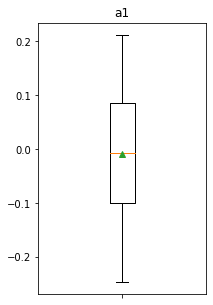

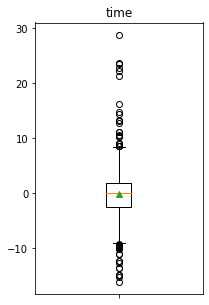

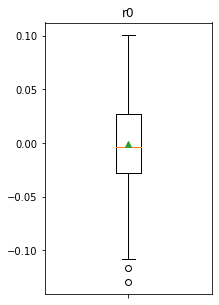

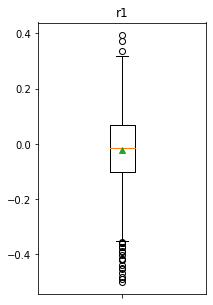

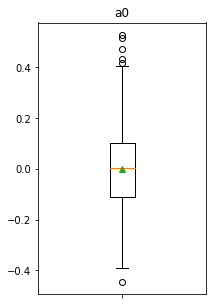

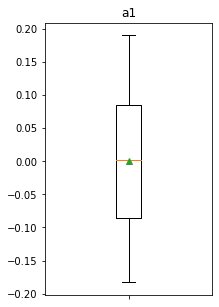

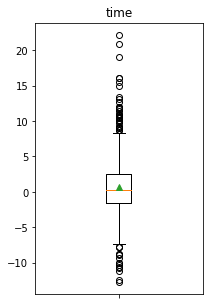

HE


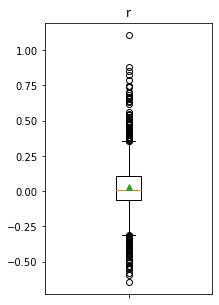

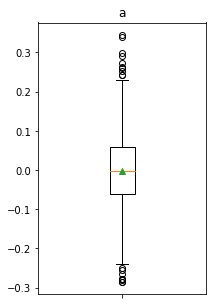

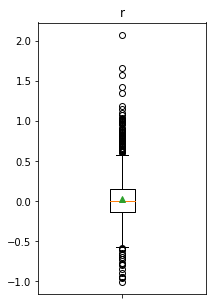

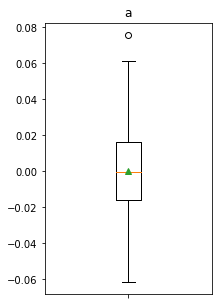

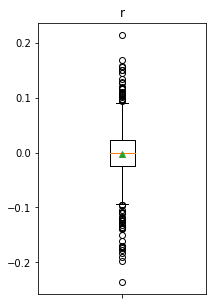

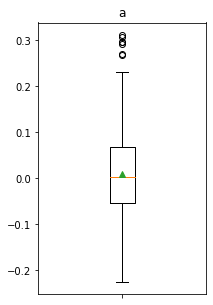

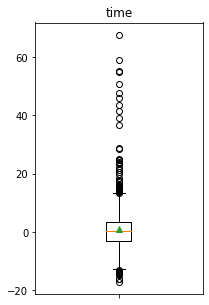

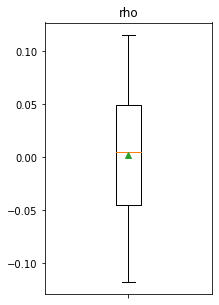

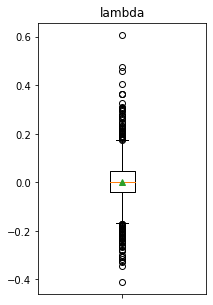

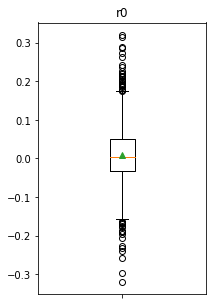

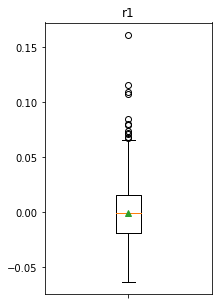

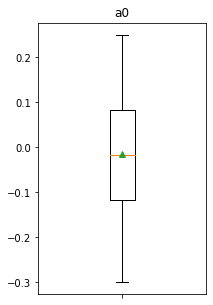

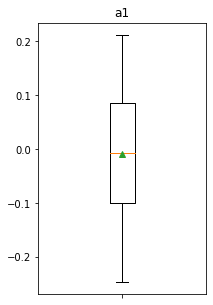

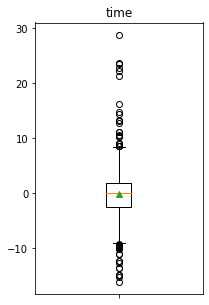

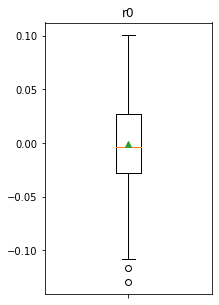

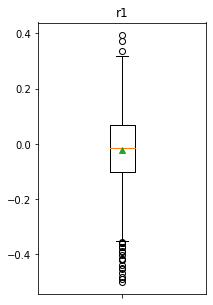

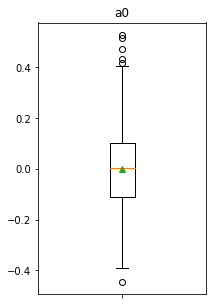

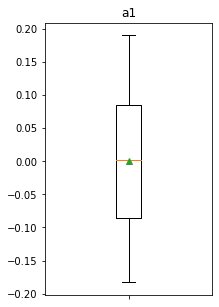

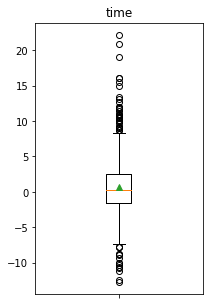

ME


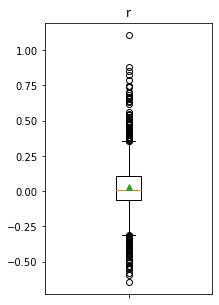

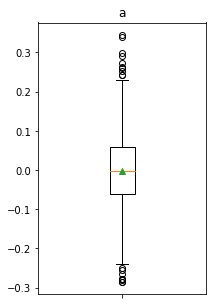

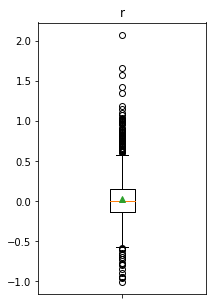

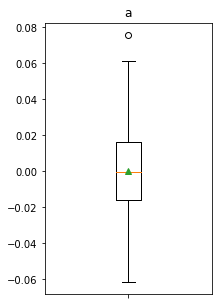

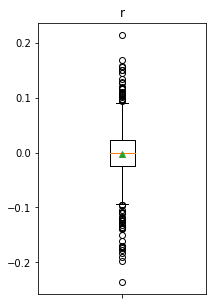

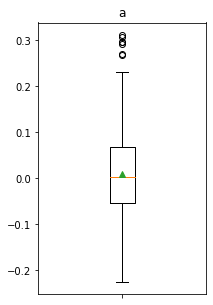

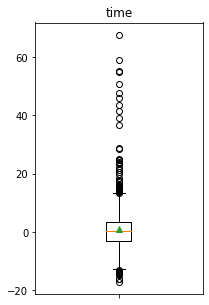

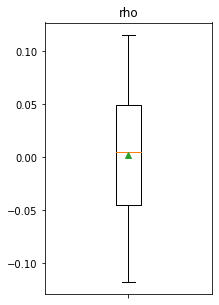

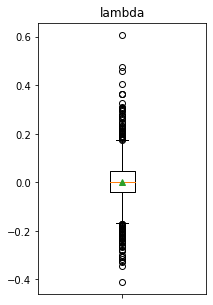

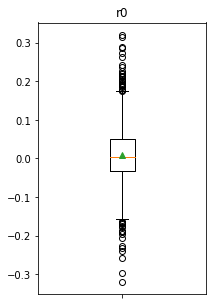

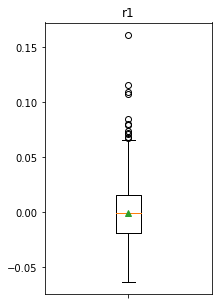

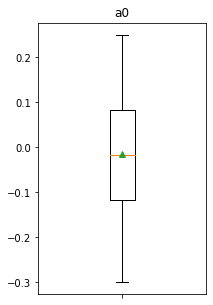

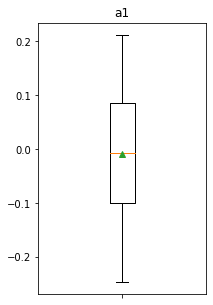

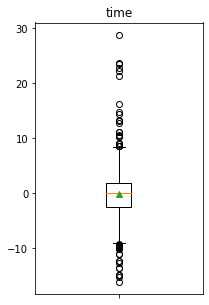

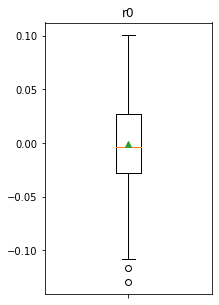

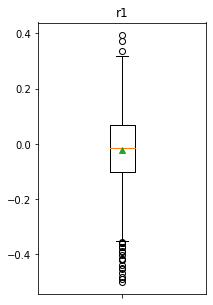

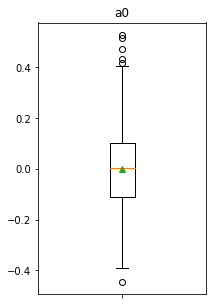

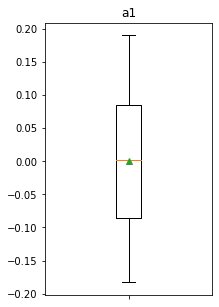

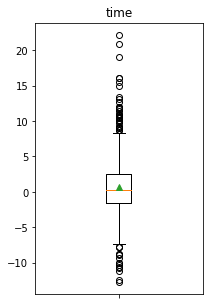

SAT


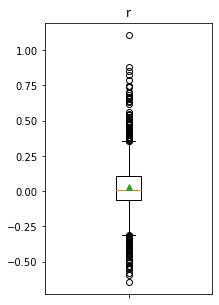

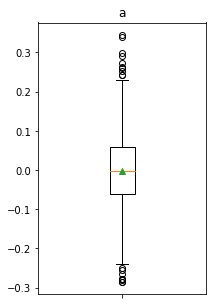

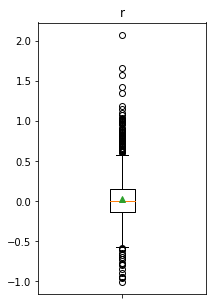

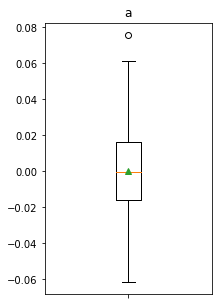

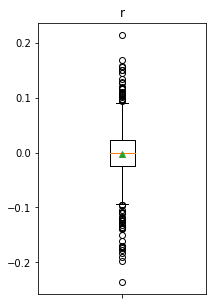

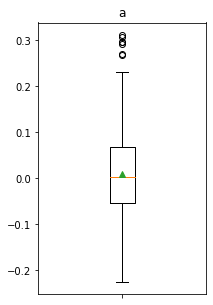

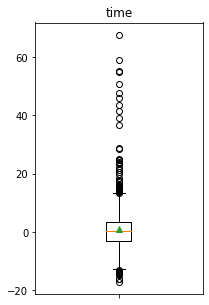

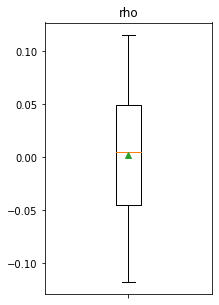

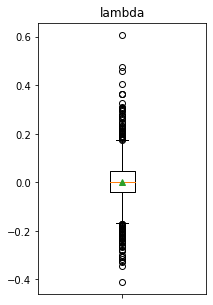

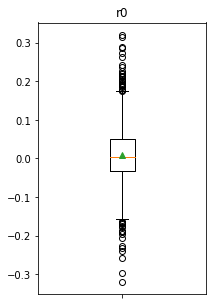

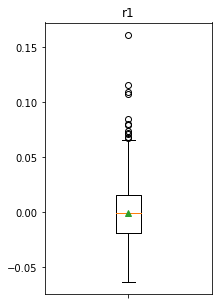

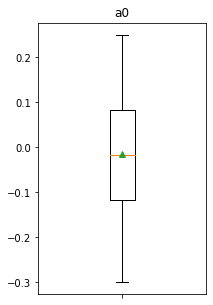

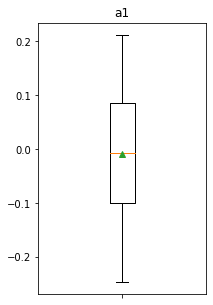

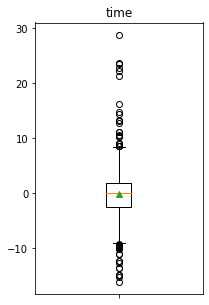

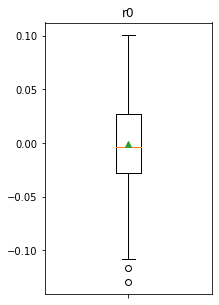

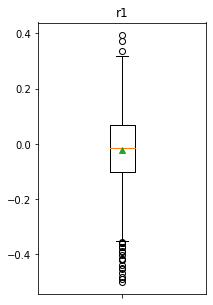

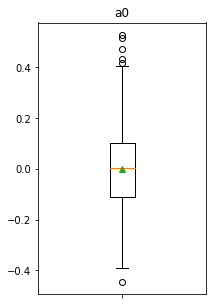

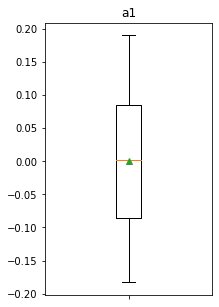

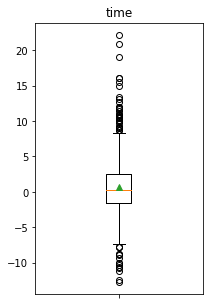

SR


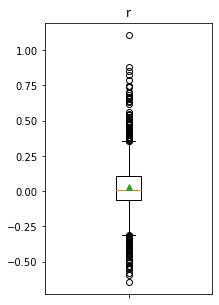

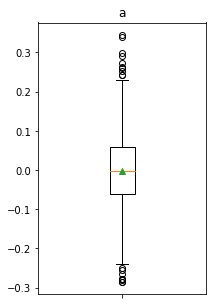

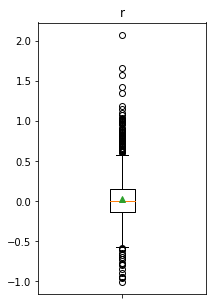

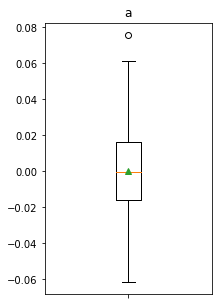

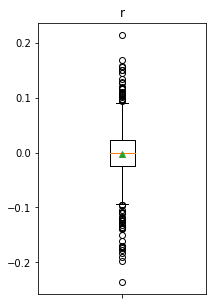

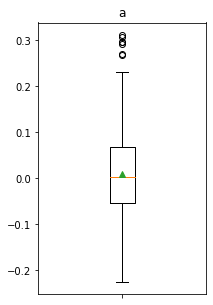

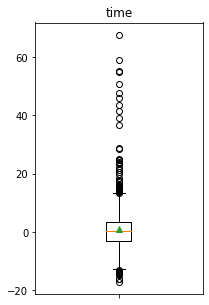

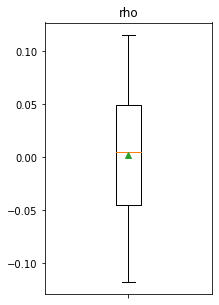

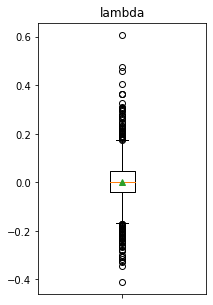

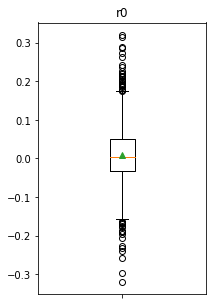

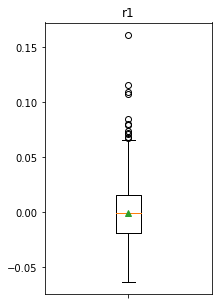

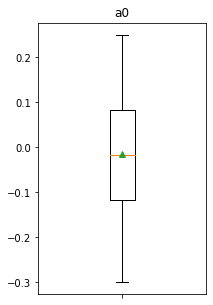

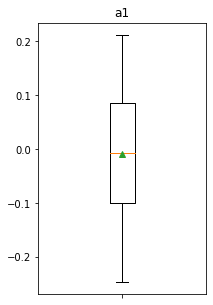

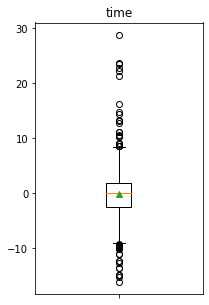

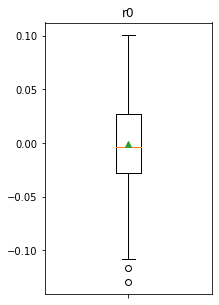

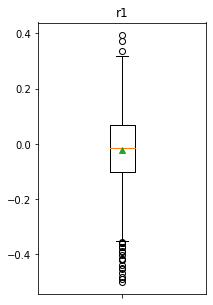

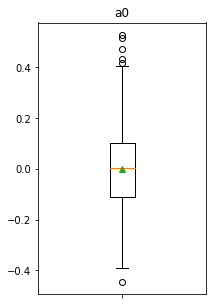

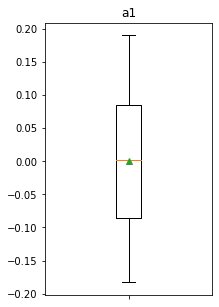

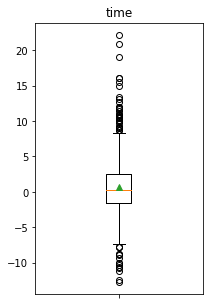

WW


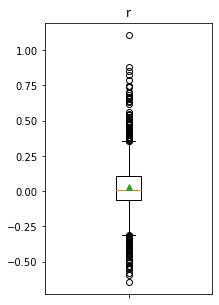

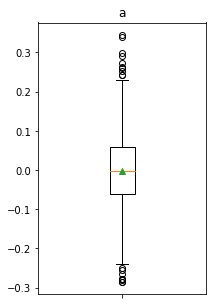

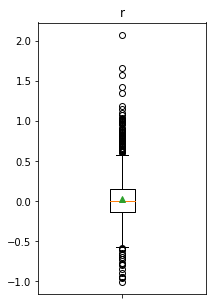

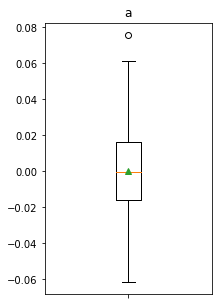

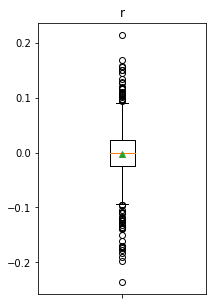

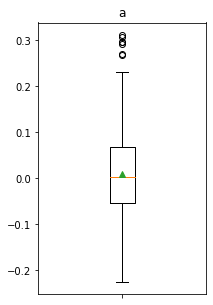

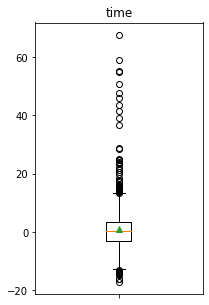

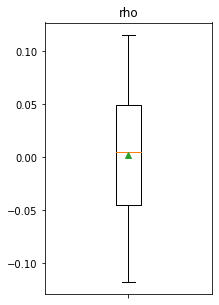

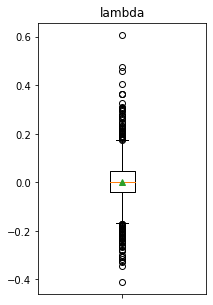

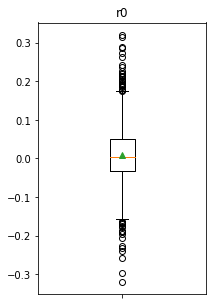

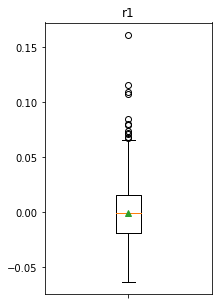

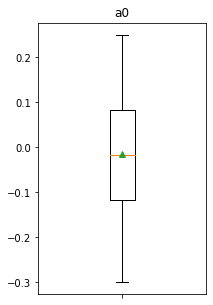

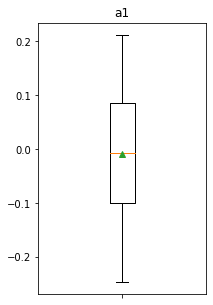

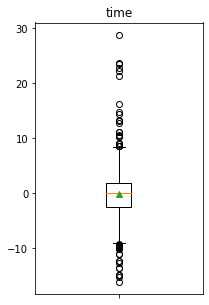

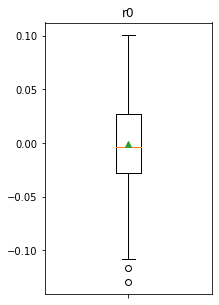

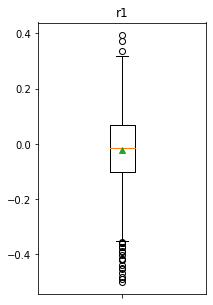

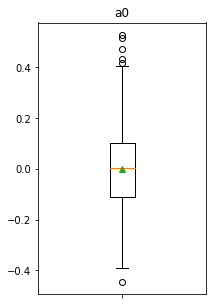

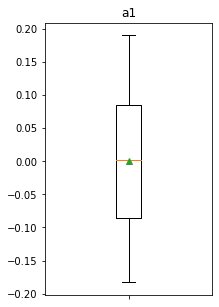

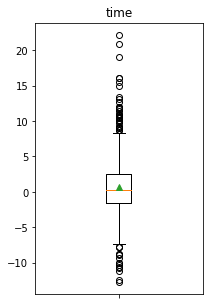

---------87---------
BD


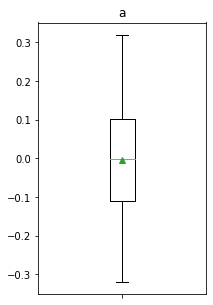

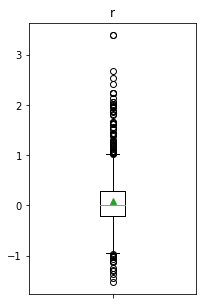

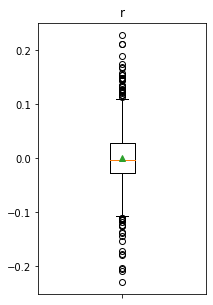

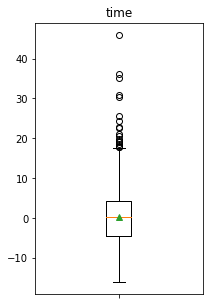

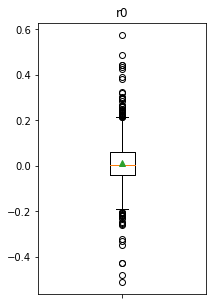

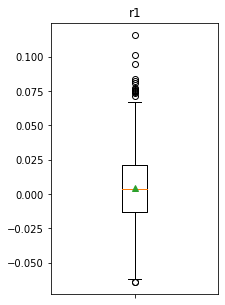

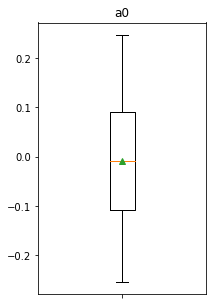

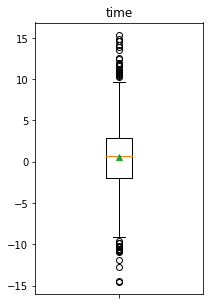

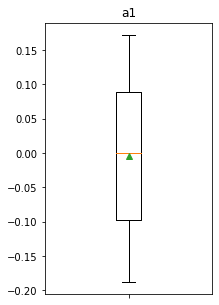

HE


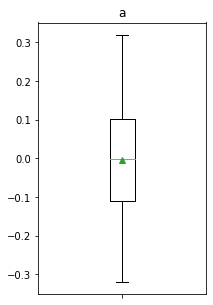

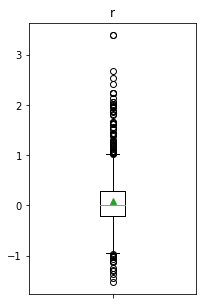

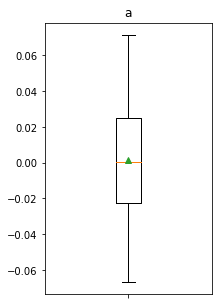

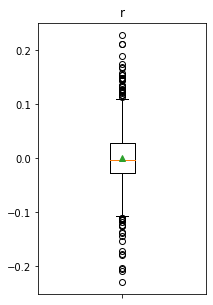

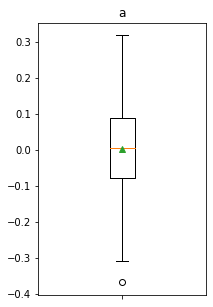

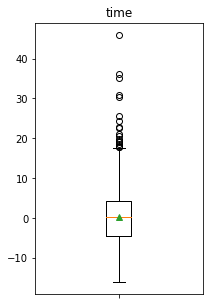

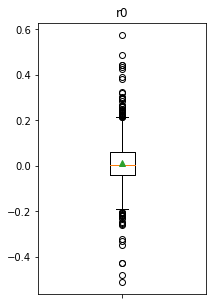

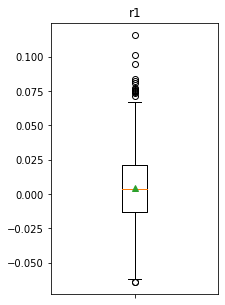

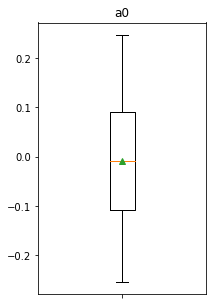

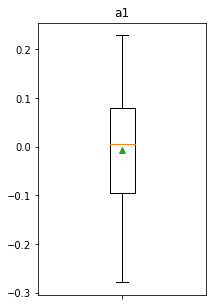

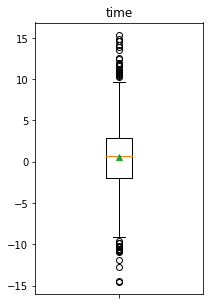

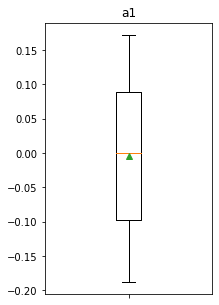

ME


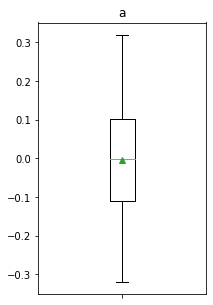

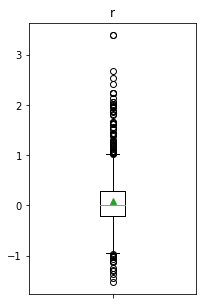

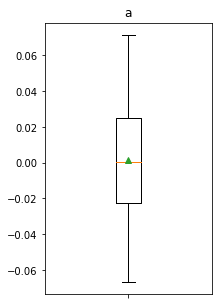

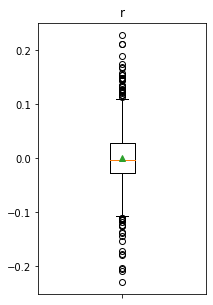

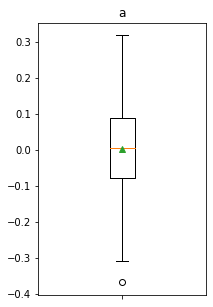

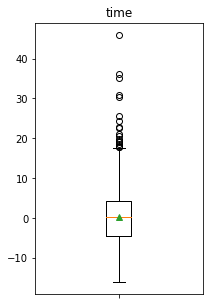

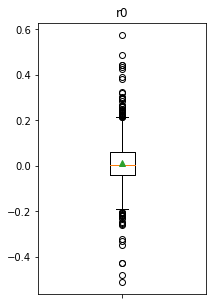

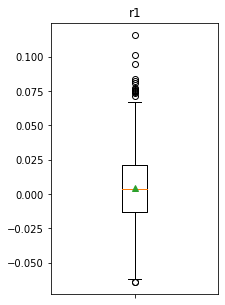

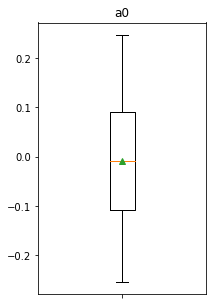

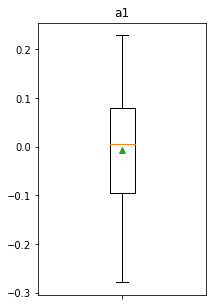

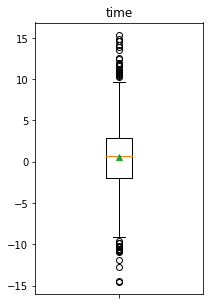

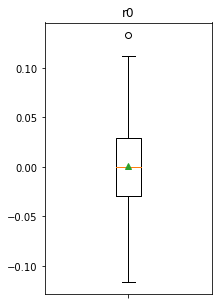

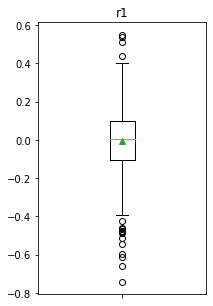

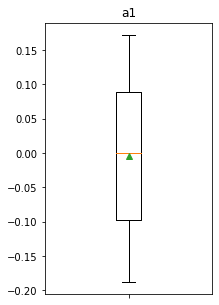

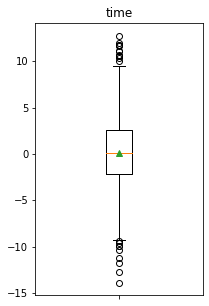

SAT


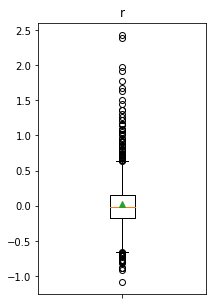

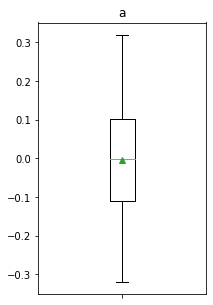

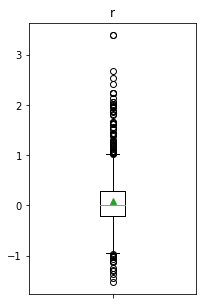

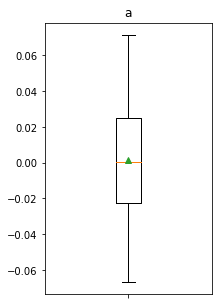

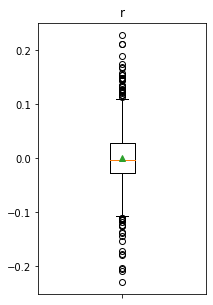

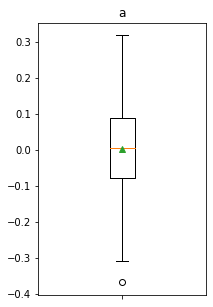

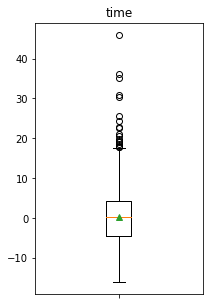

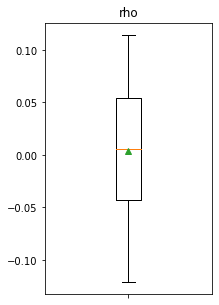

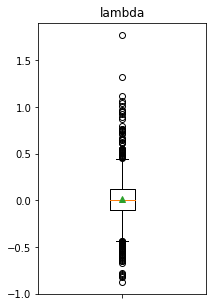

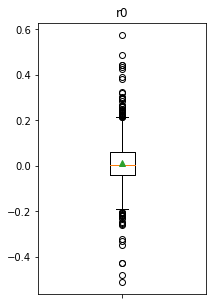

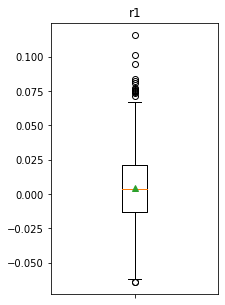

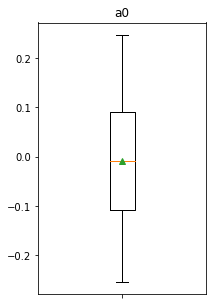

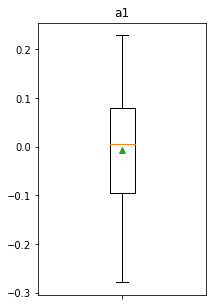

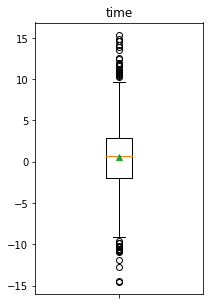

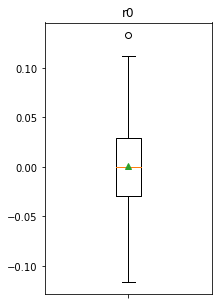

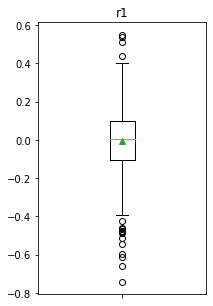

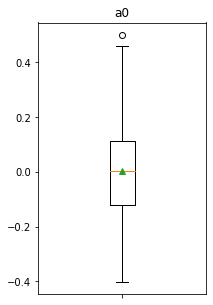

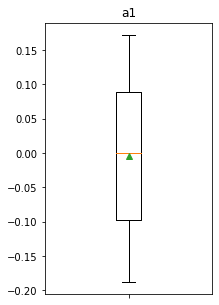

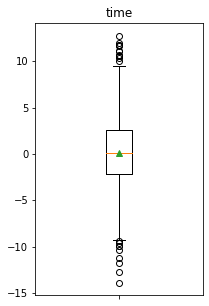

SR


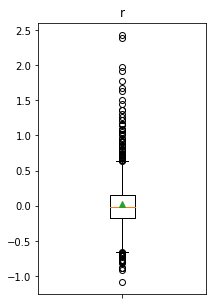

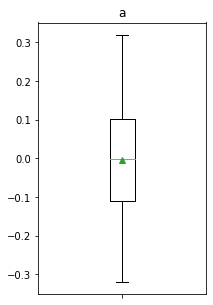

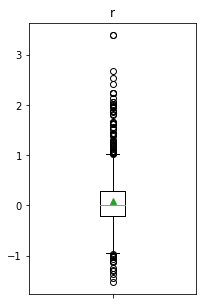

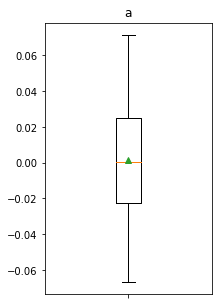

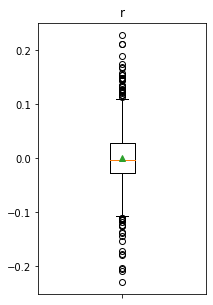

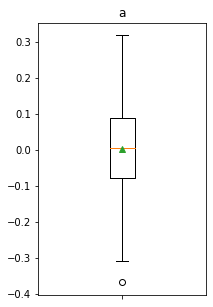

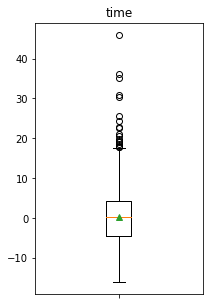

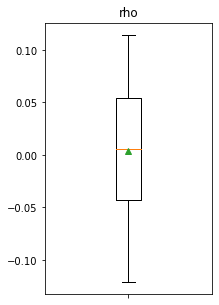

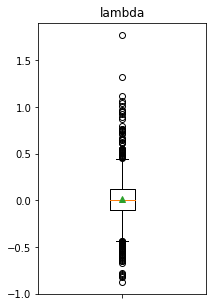

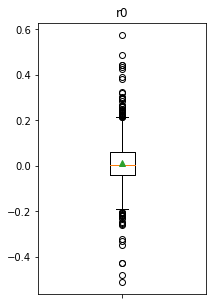

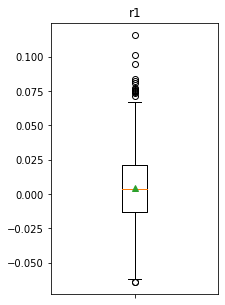

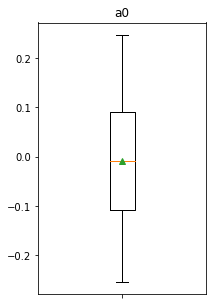

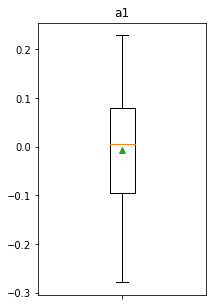

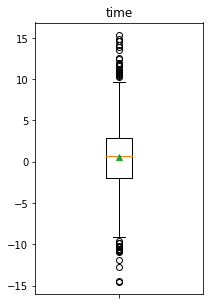

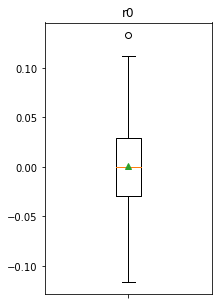

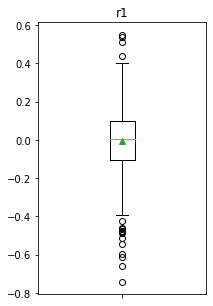

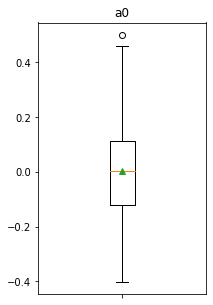

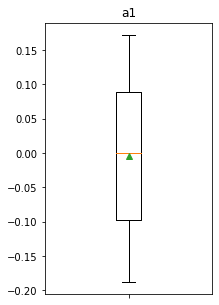

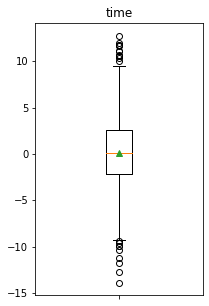

WW


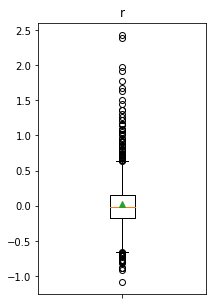

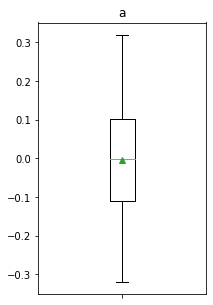

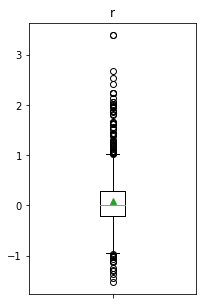

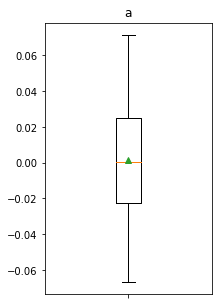

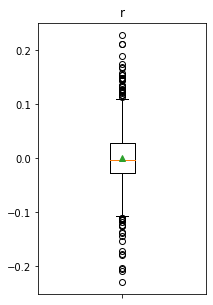

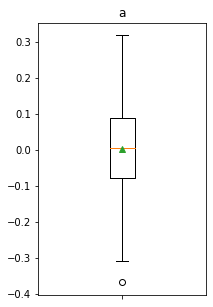

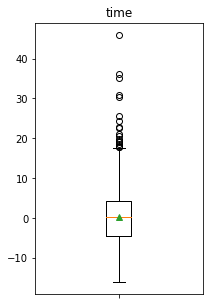

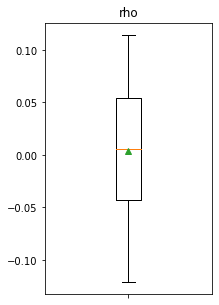

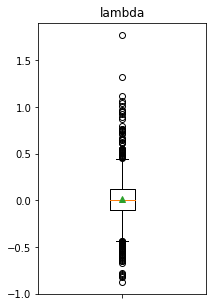

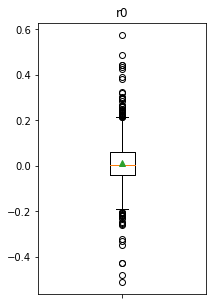

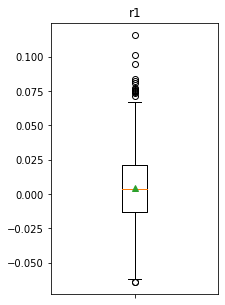

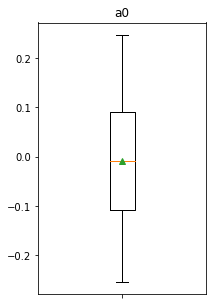

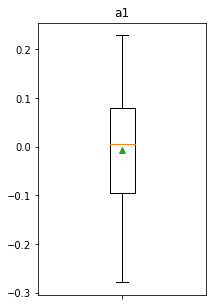

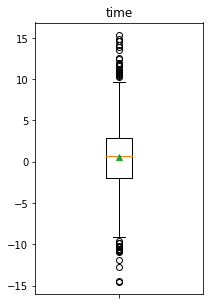

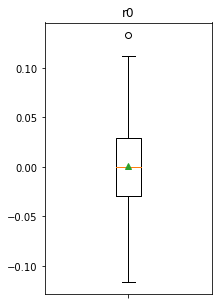

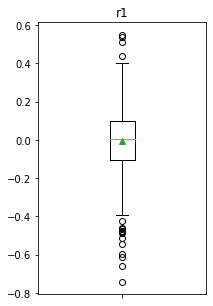

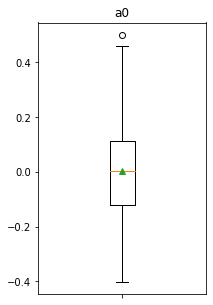

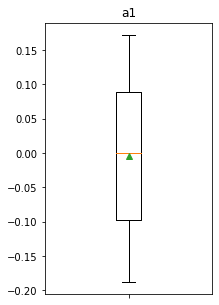

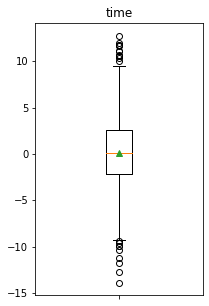

In [14]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios:
        print(scenario)
        plot_errors_boxplot(results, tip, scenario)

### Errors swarmplots 

---------674---------
BD


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


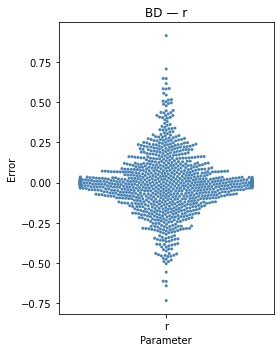

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
HE


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


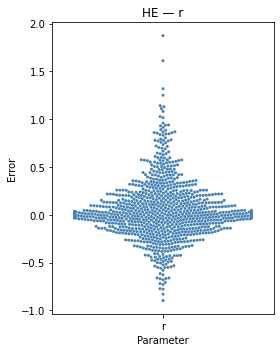

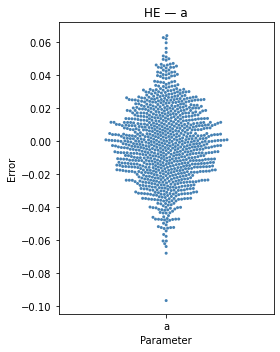

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
ME


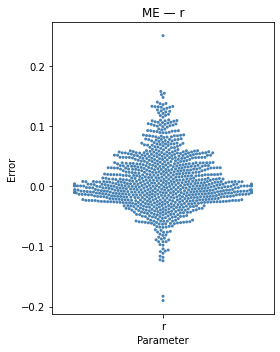

/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


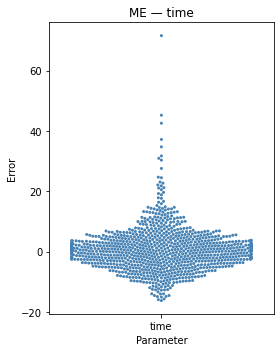

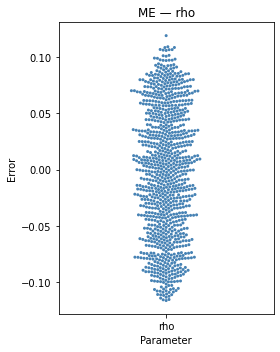

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
SAT


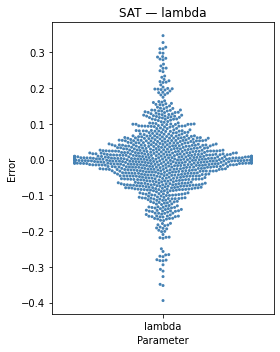

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
SR


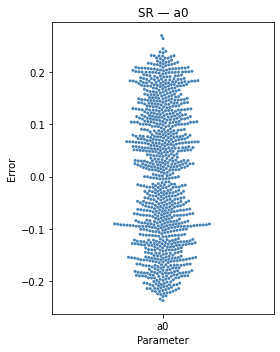

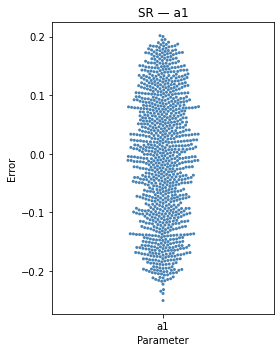

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
WW


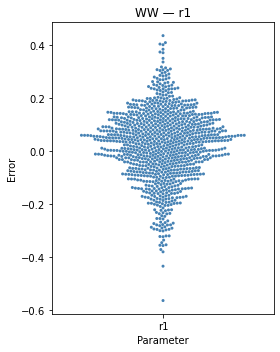

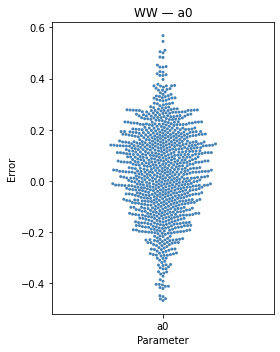

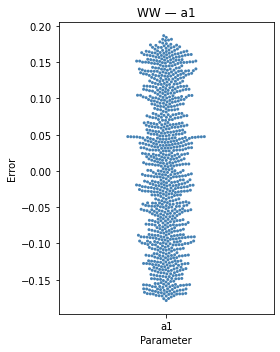

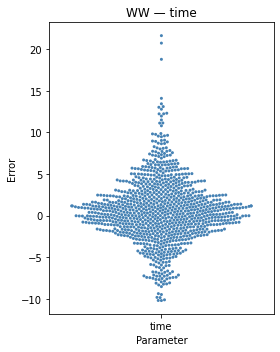

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
---------489---------
BD


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


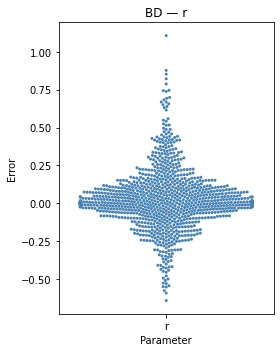

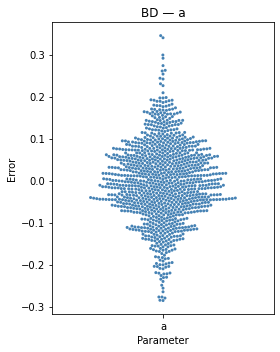

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
HE


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


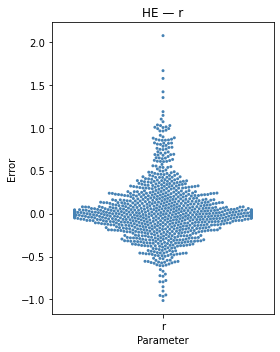

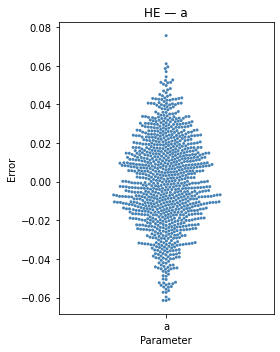

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
ME


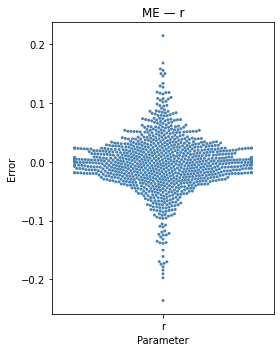

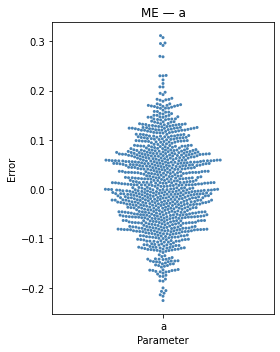

/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


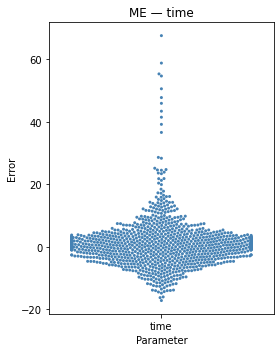

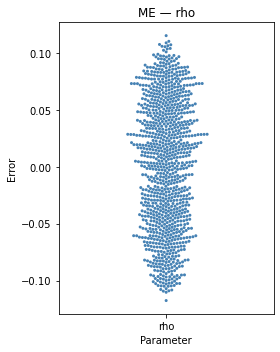

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
SAT


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


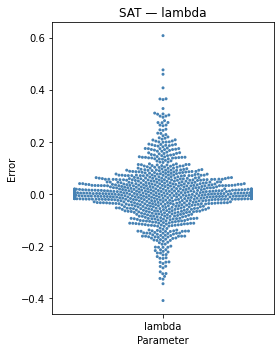

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
SR


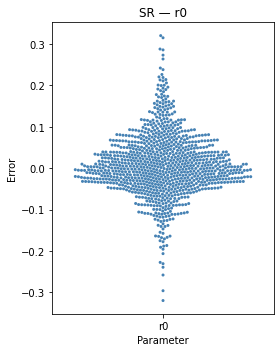

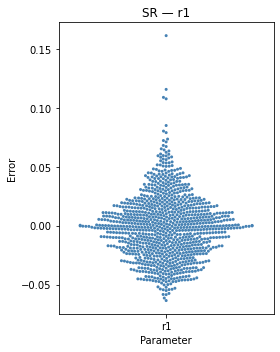

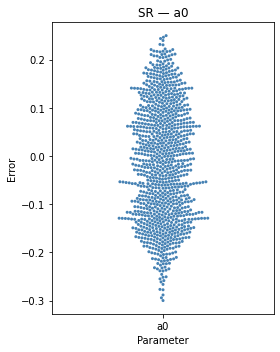

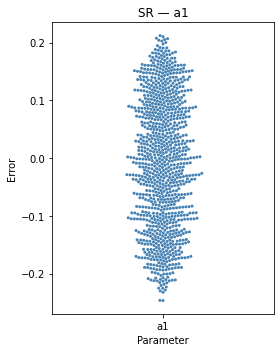

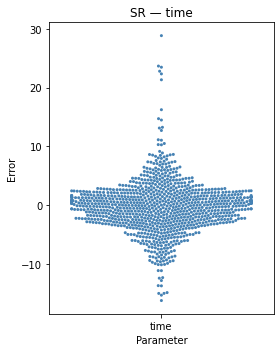

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
WW


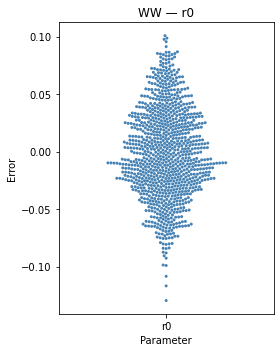

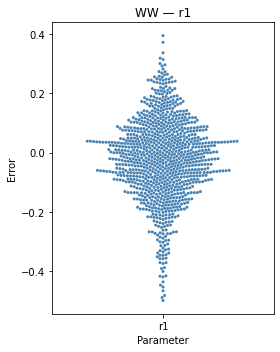

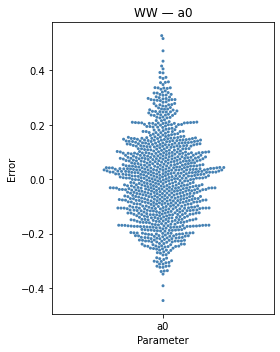

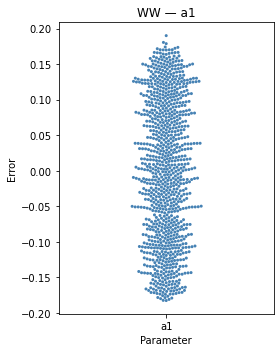

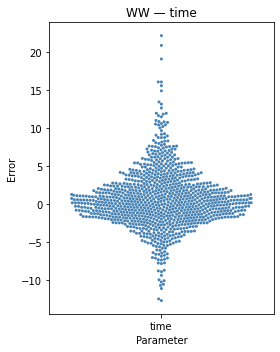

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
---------87---------
BD


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


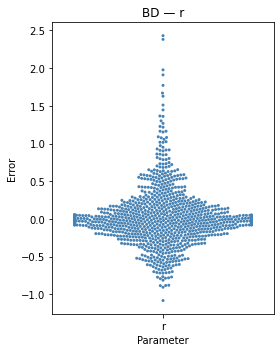

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
HE


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


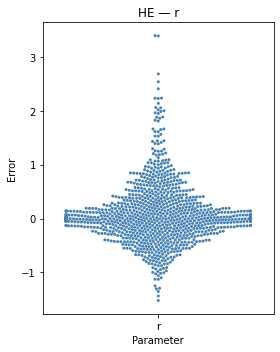

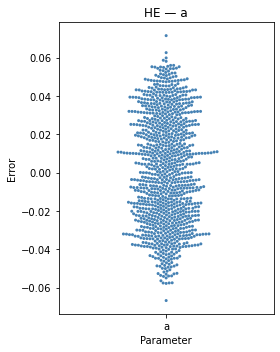

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
ME


        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
SAT


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


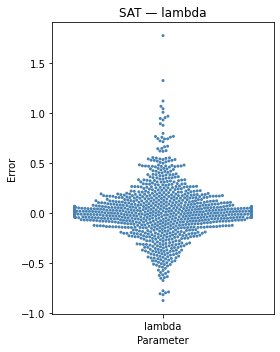

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
SR


/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


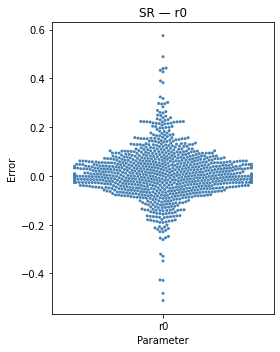

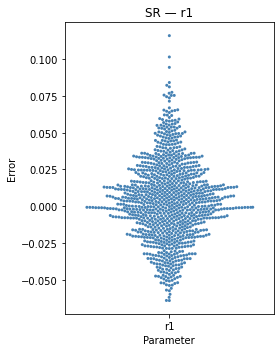

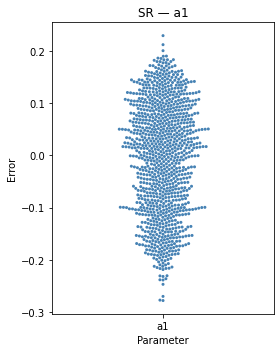

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111
WW


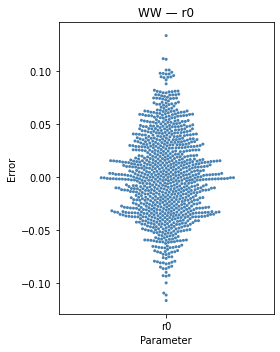

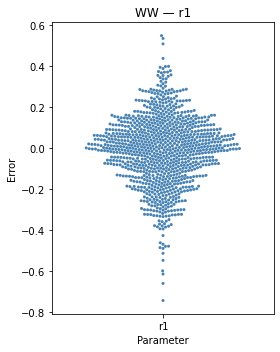

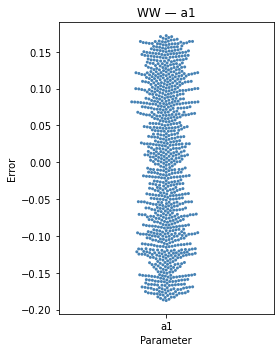

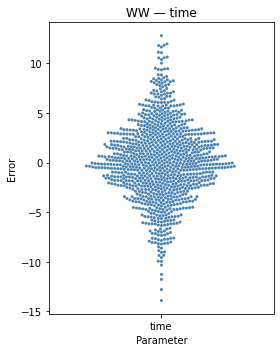

        r0     r1     a0     a1   time
MAE 0.0323 0.1296 0.1381 0.0912 3.0111


In [17]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios:
        print(scenario)
        plot_errors(results, tip, scenario)

### Absolute errors vs target

---------674---------


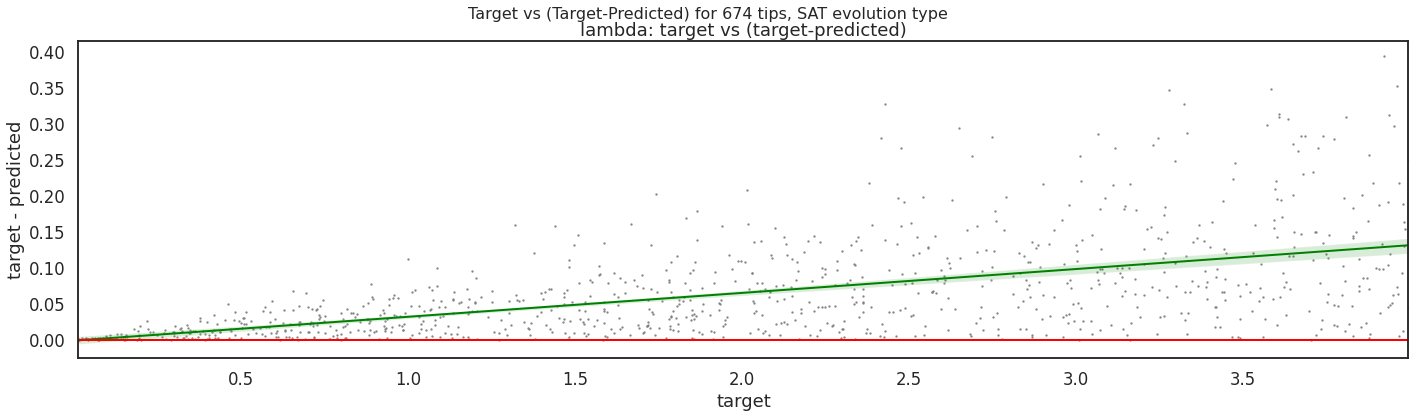

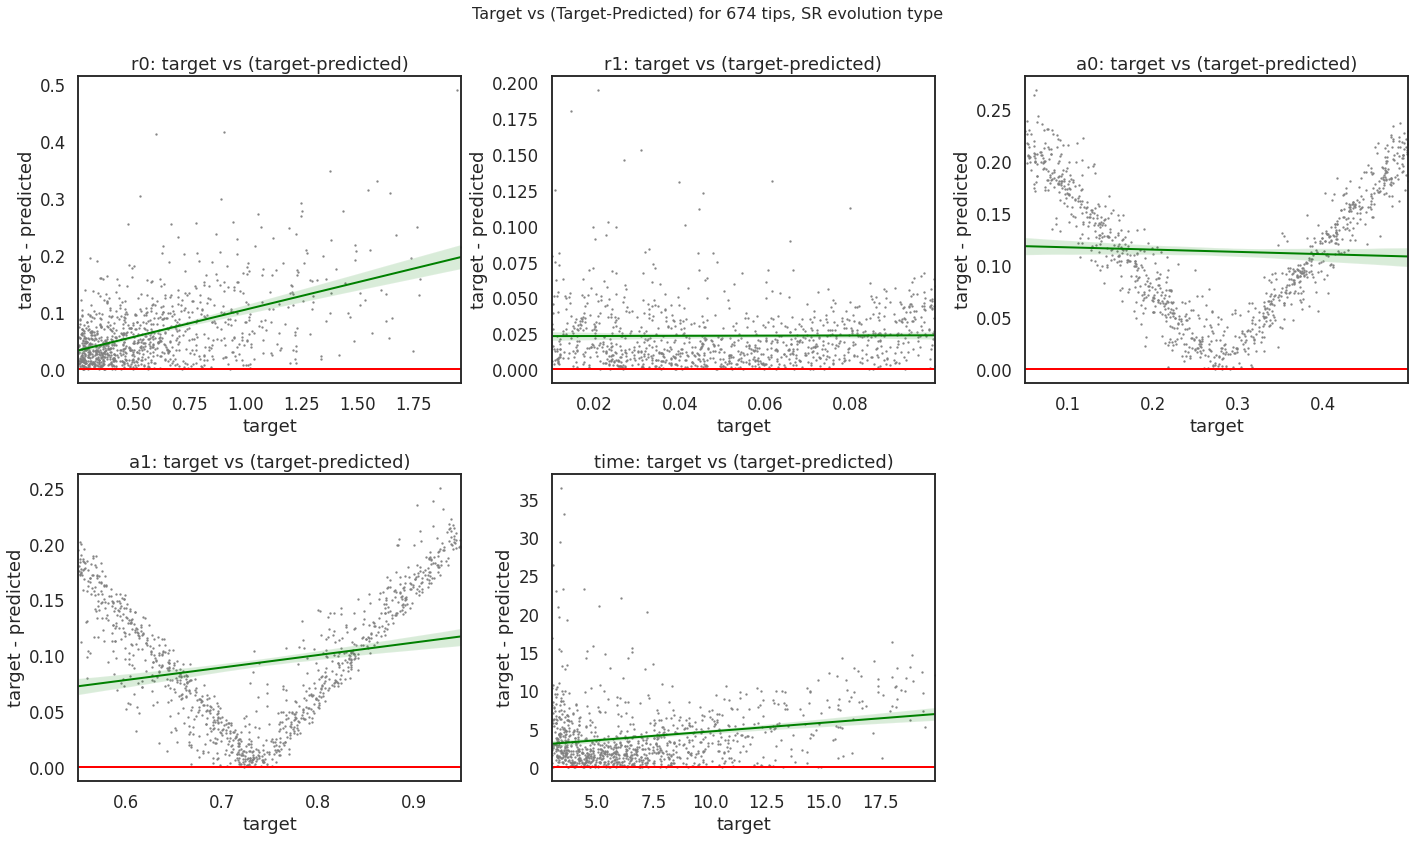

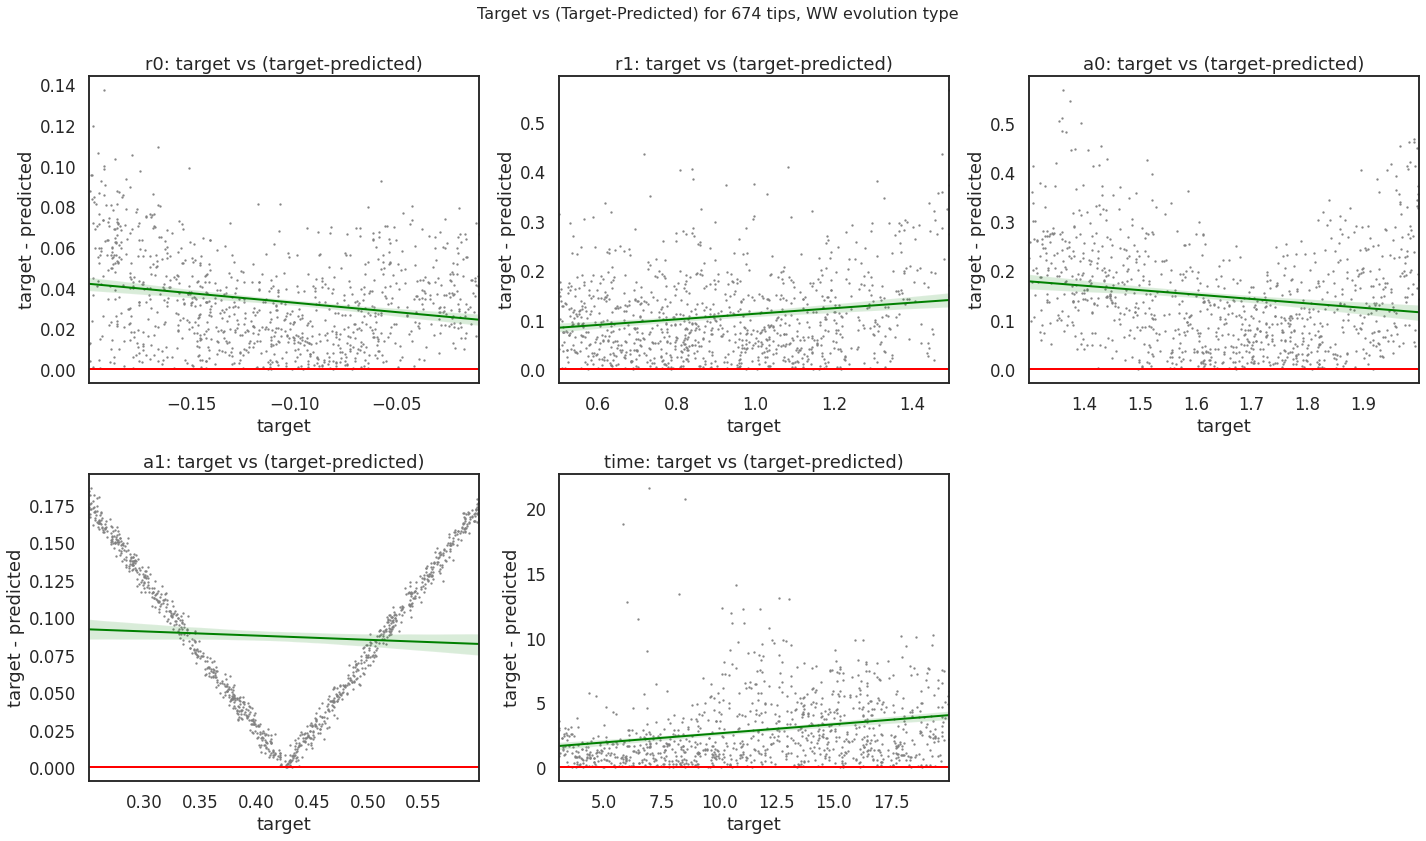

---------489---------


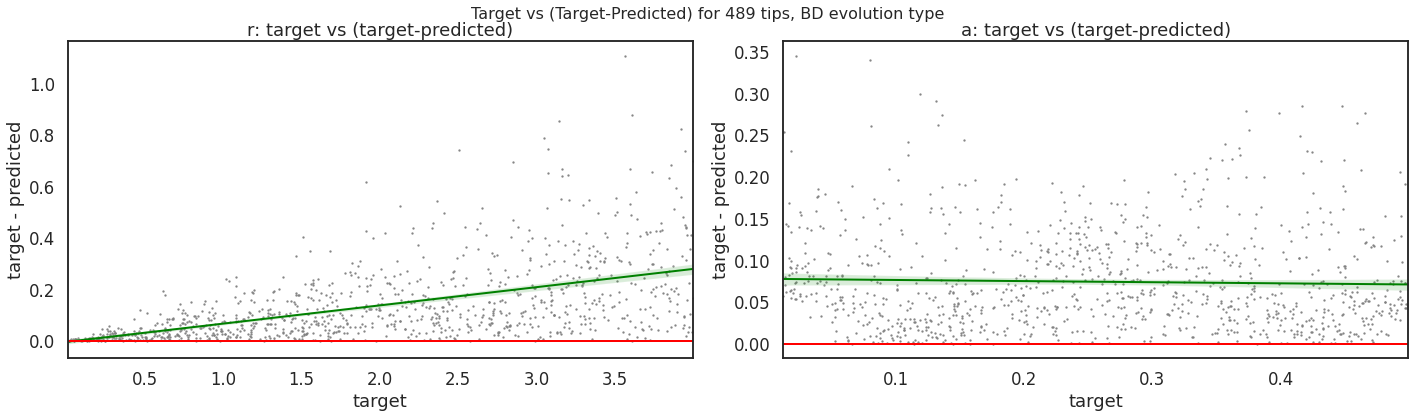

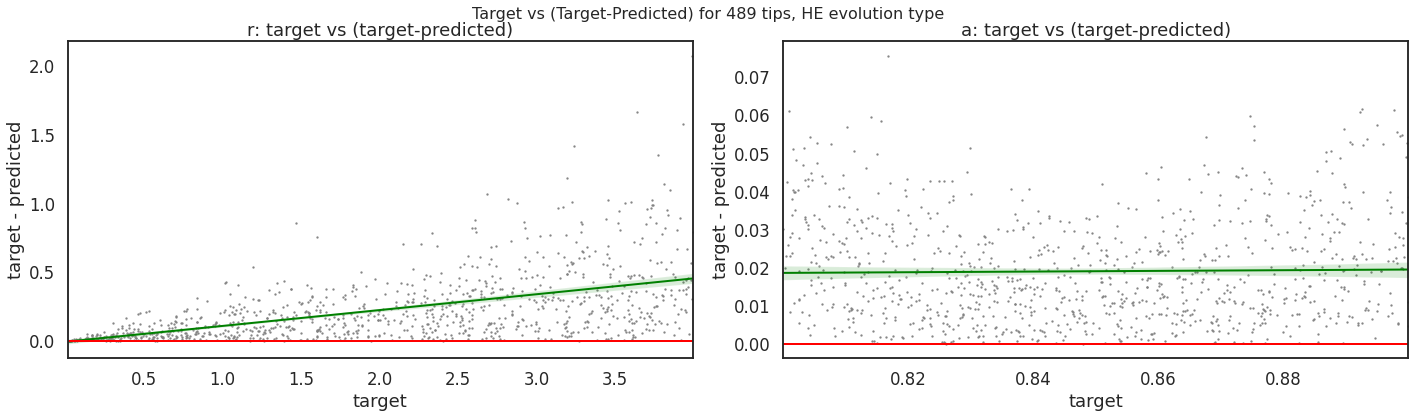

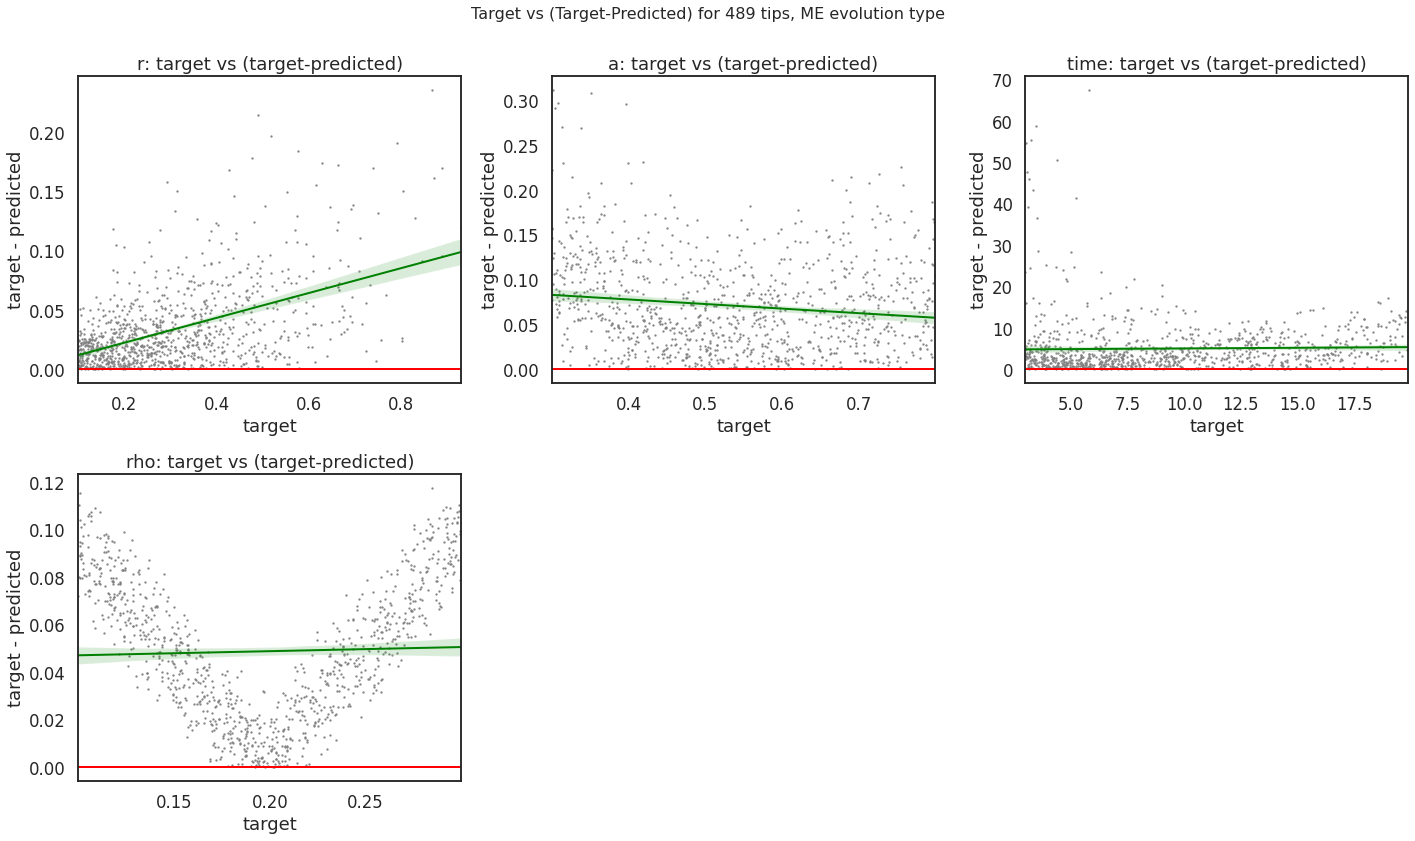

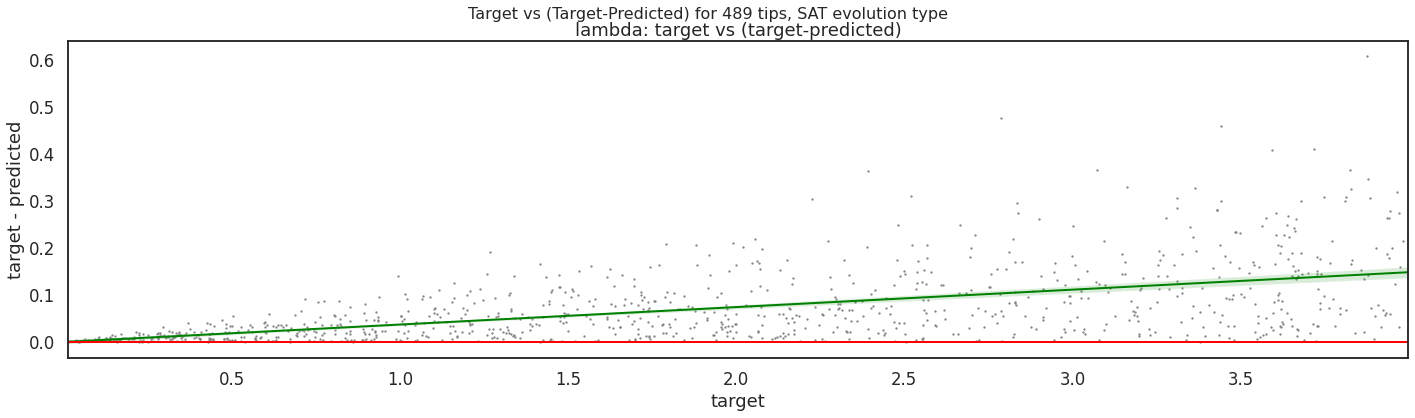

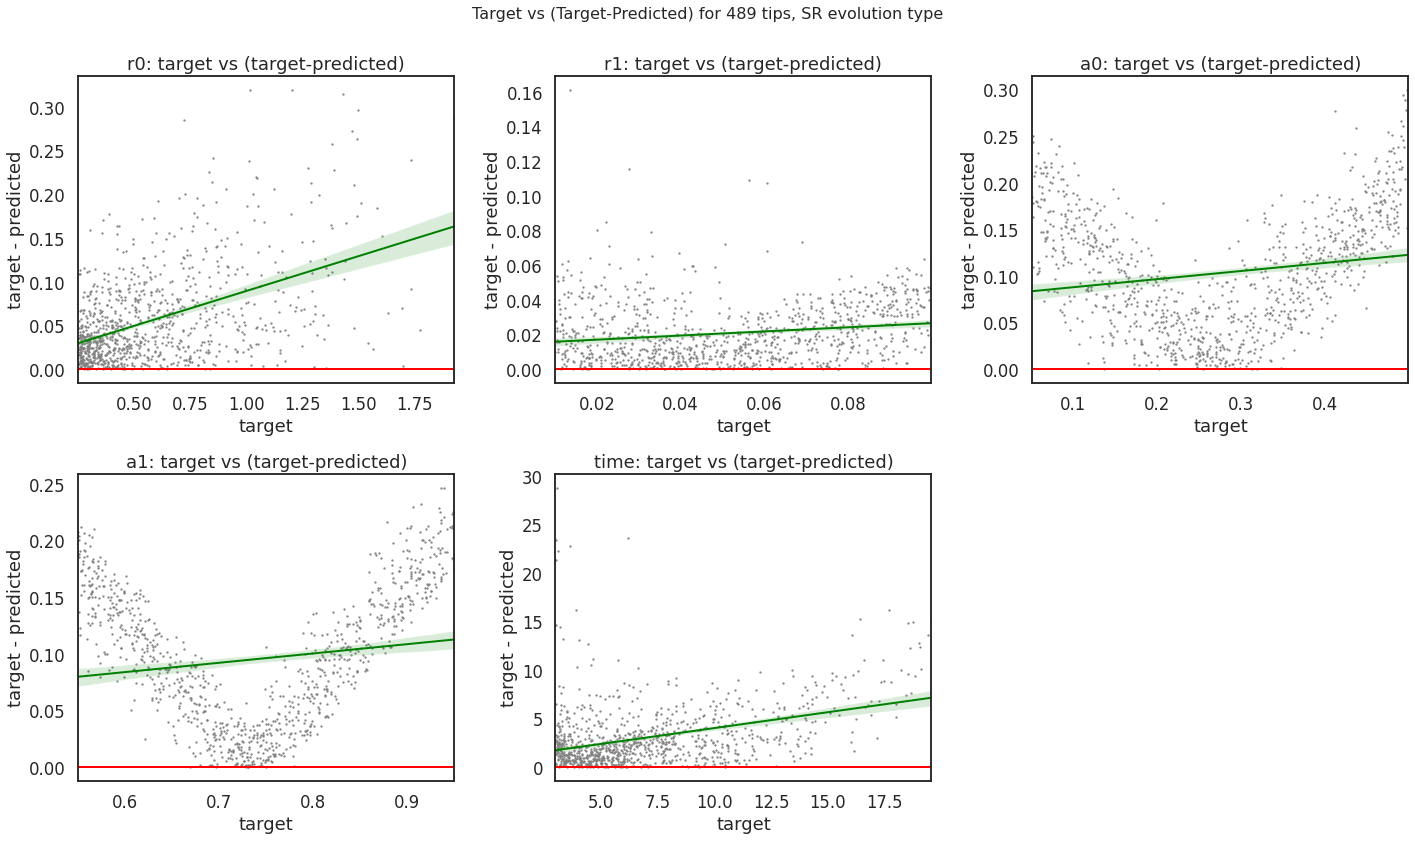

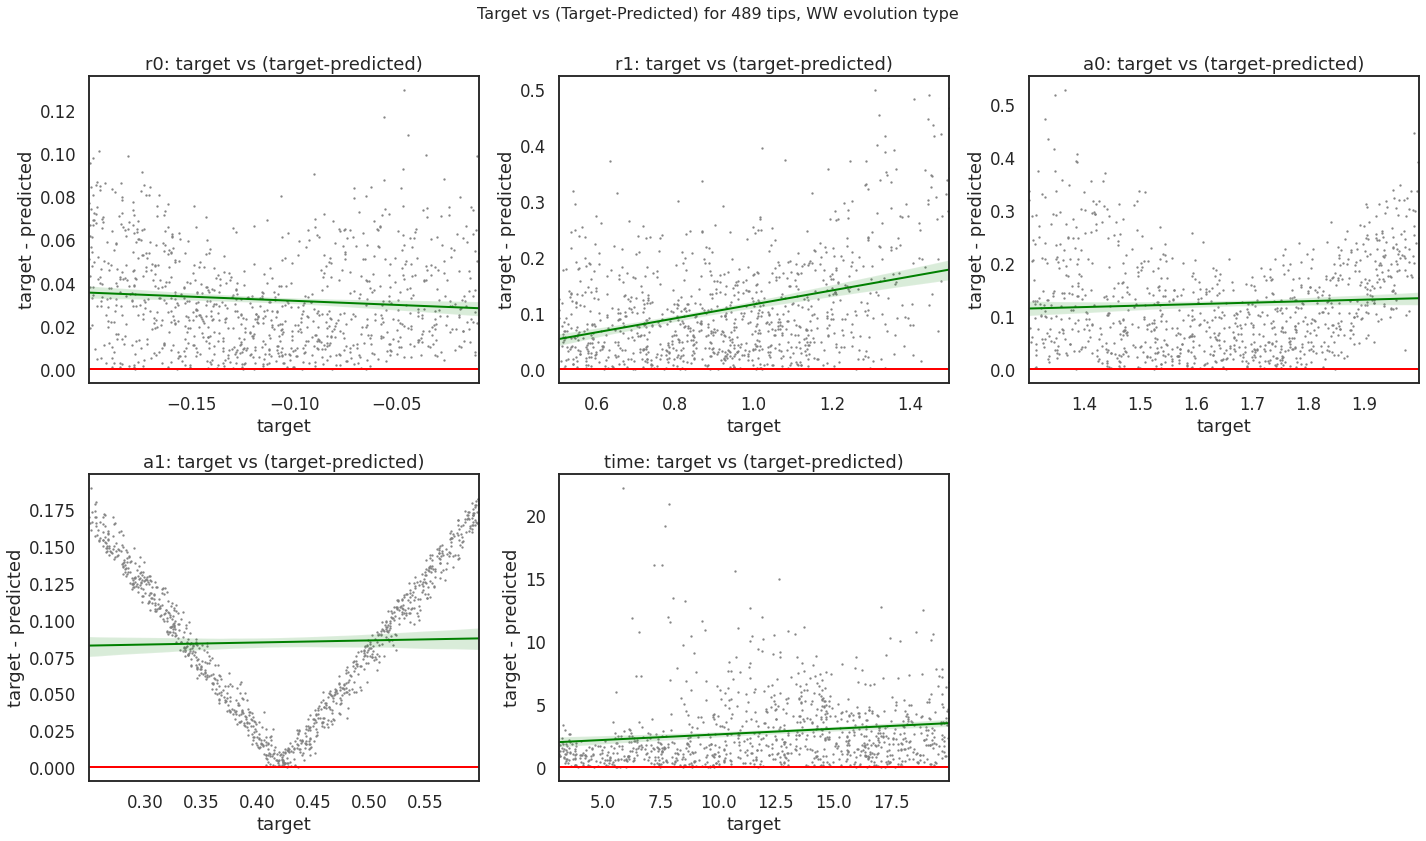

---------87---------


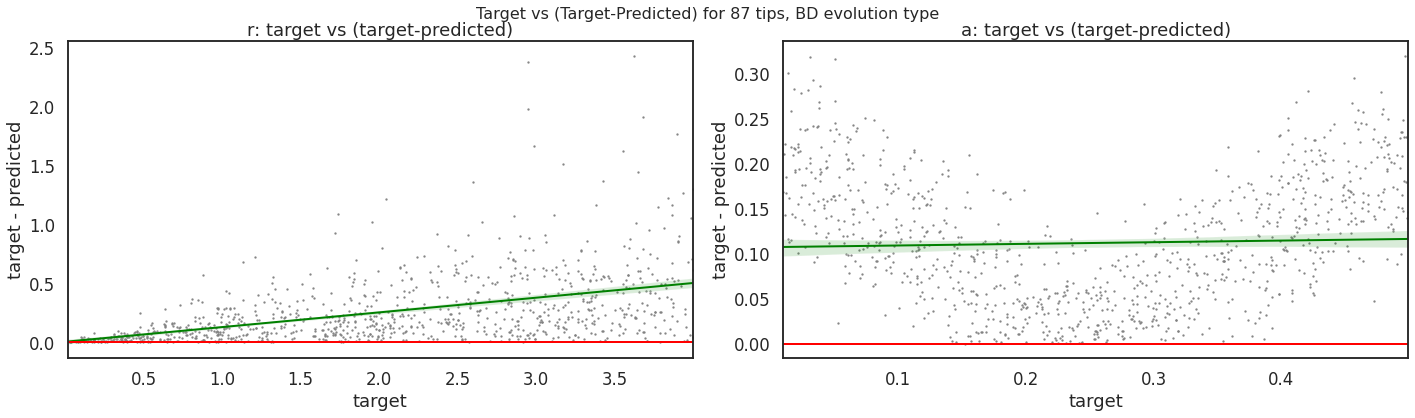

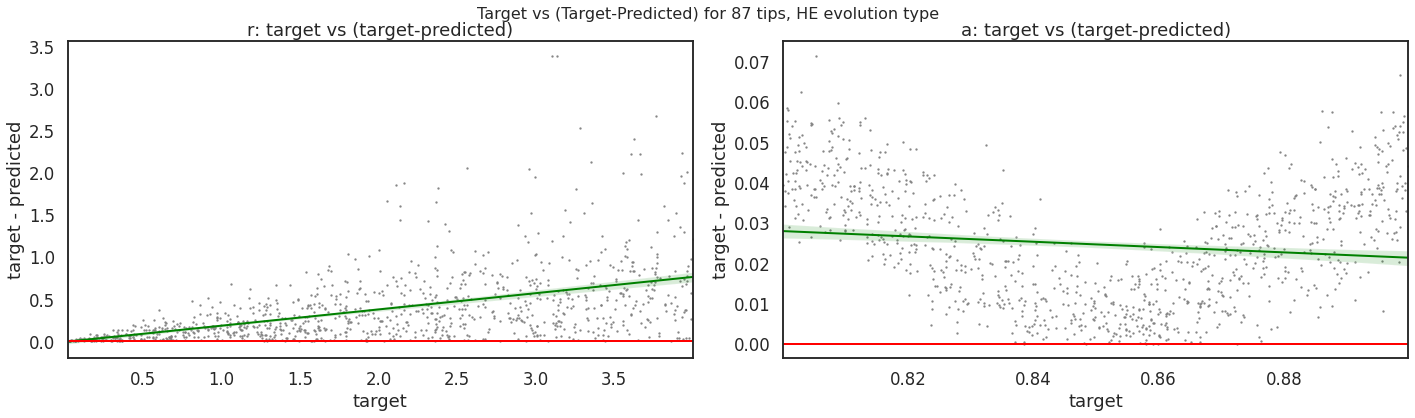

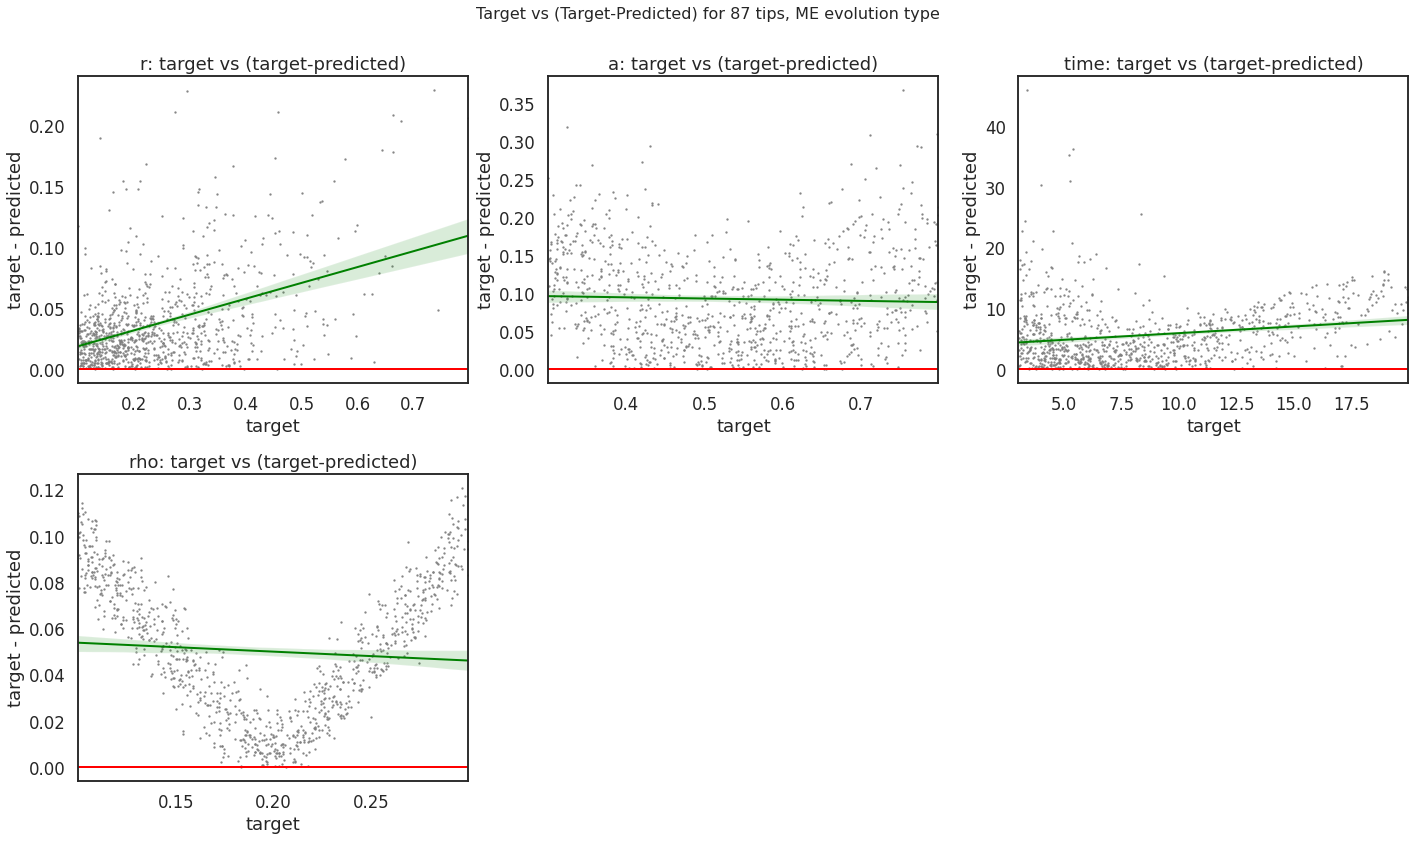

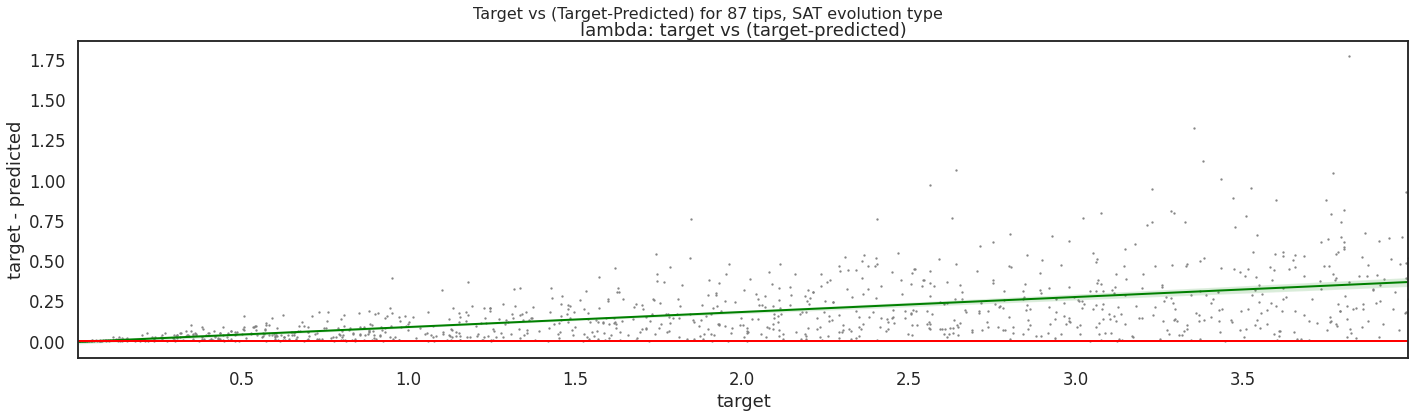

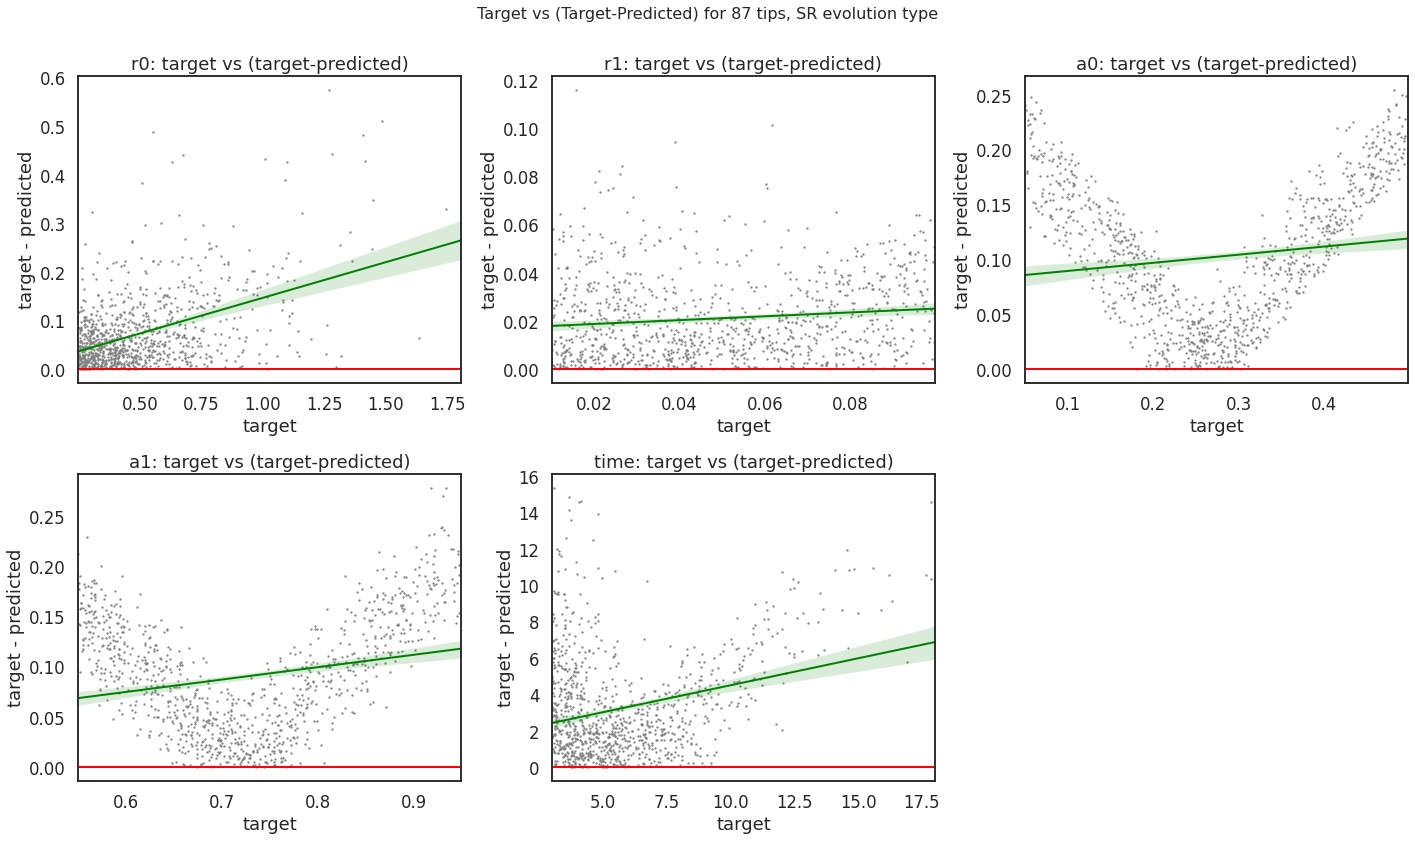

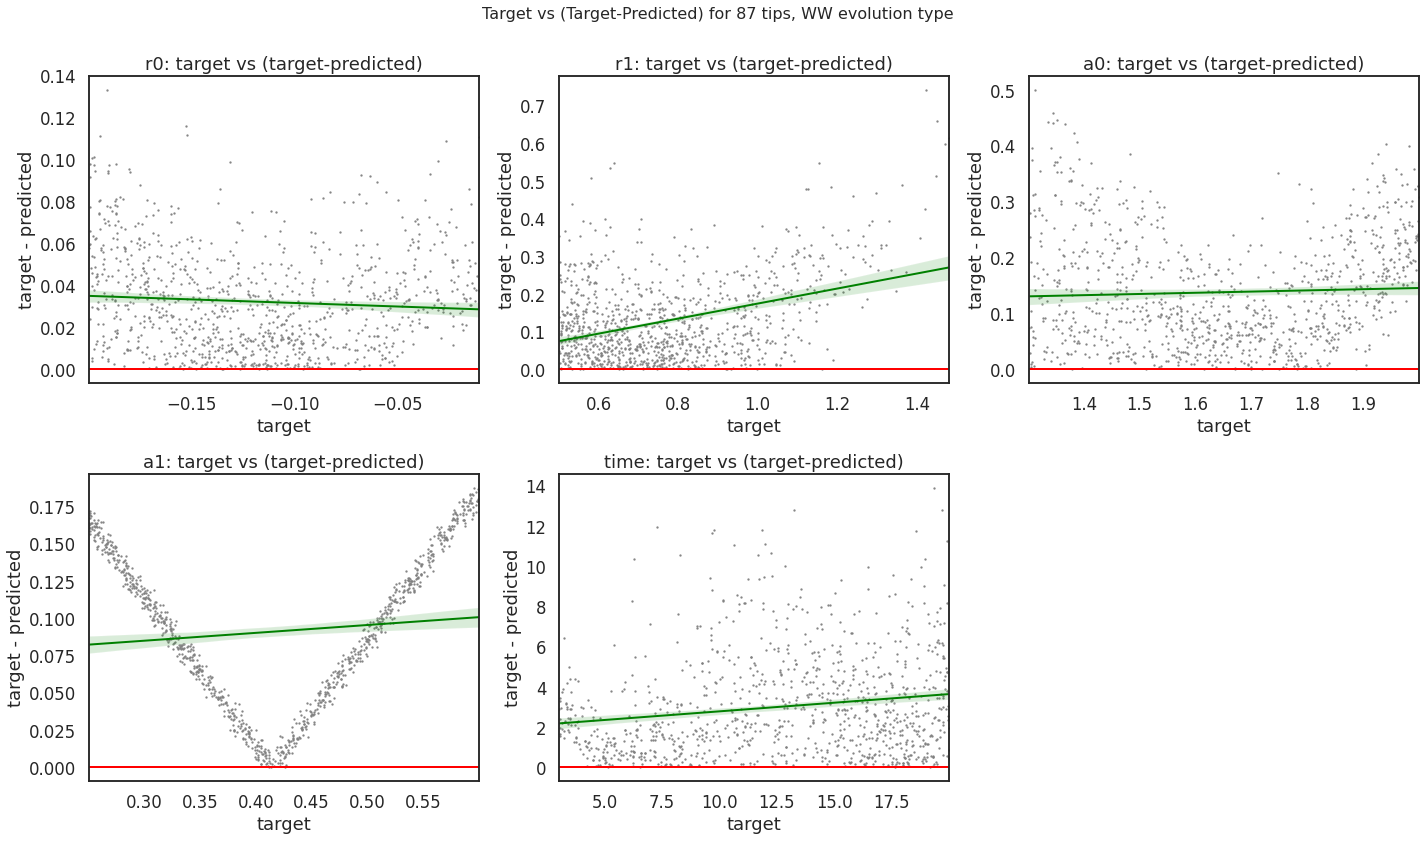

In [67]:
for tip in n_tips: 
    print("---------" + str(tip) + "---------" )
    for scenario in div_scenarios:
        predicted_minus_target_vs_target(results, tip, scenario)